# MNIST: Log-Linear Model v.s. Autoencoder

In [1]:
import os
os.environ["PYTHONWARNINGS"] = "ignore"

import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

from sklearn.neighbors import KernelDensity

from tqdm import tqdm

import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
from PIL import Image

from joblib import Parallel, delayed

import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))

import ld

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
def renormalize_image(image, threshold=False, threshold_value=10):
    """
    Renormalize an image such that pixel values are between 0 and 255.
    Optionally, set small pixel values to 0.

    Parameters:
    - image: numpy array with shape (28, 28)
    - threshold: bool, if True, set small pixel values to 0
    - threshold_value: int, the value below which pixels are set to 0 (if threshold is True)

    Returns:
    - renormalized_image: numpy array with shape (28, 28), pixel values between 0 and 255
    """
    # Ensure the image is a numpy array
    image = np.array(image)

    # Renormalize pixel values to be between 0 and 255
    min_val = np.min(image)
    max_val = np.max(image)
    renormalized_image = 255 * (image - min_val) / (max_val - min_val)

    # Apply threshold if needed
    if threshold:
        renormalized_image[renormalized_image < threshold_value] = 0

    return renormalized_image.astype(np.uint8)

def vectorize_tensor(T, B):
    """
    Vectorizes the tensor T by selecting only the indices in B.

    Parameters:
    - T: numpy array of shape (num_samples, ...)
    - B: list of indices to select from each sample

    Returns:
    - V: vectorized representation of T of shape (num_samples, len(B))
    """
    num_samples = T.shape[0]
    V = np.zeros((num_samples, len(B)))
    for i in range(num_samples):
        for j, idx in enumerate(B):
            V[i, j] = T[i, *idx]
    return V

def reconstruct_tensor(V, T_shape, B):
    """
    Reconstructs the tensor T from its vectorized representation V.

    Parameters:
    - V: vectorized representation of T of shape (num_samples, len(B))
    - T_shape: original shape of the tensor T
    - B: list of indices that were used to create the vectorized representation

    Returns:
    - T: reconstructed tensor with the original shape, missing values filled with zero
    """
    num_samples = V.shape[0]
    T = np.zeros(T_shape)
    for i in range(num_samples):
        for j, idx in enumerate(B):
            T[i, *idx] = V[i, j]
    return T

## Setup

### Dataset

In [3]:
D = 28*28
S = (7, 2, 2, 7, 2, 2)
train_size = 100
plot_num = 20
paper_plot_num = 1
eps = np.asarray(1.0e-5)

In [4]:
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', download=True, train=True, transform=transform)

save_dir = './data/MNIST_images'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    # Save images by class
    for class_label in range(10):
        class_dir = os.path.join(save_dir, str(class_label))
        if not os.path.exists(class_dir):
            os.makedirs(class_dir)

        basis = np.where(train_dataset.targets.numpy() == class_label)[0]
        for i, idx in enumerate(basis):
            img, _ = train_dataset[idx]
            img = transforms.ToPILImage()(img)
            img.save(os.path.join(class_dir, f'{i}.png'))

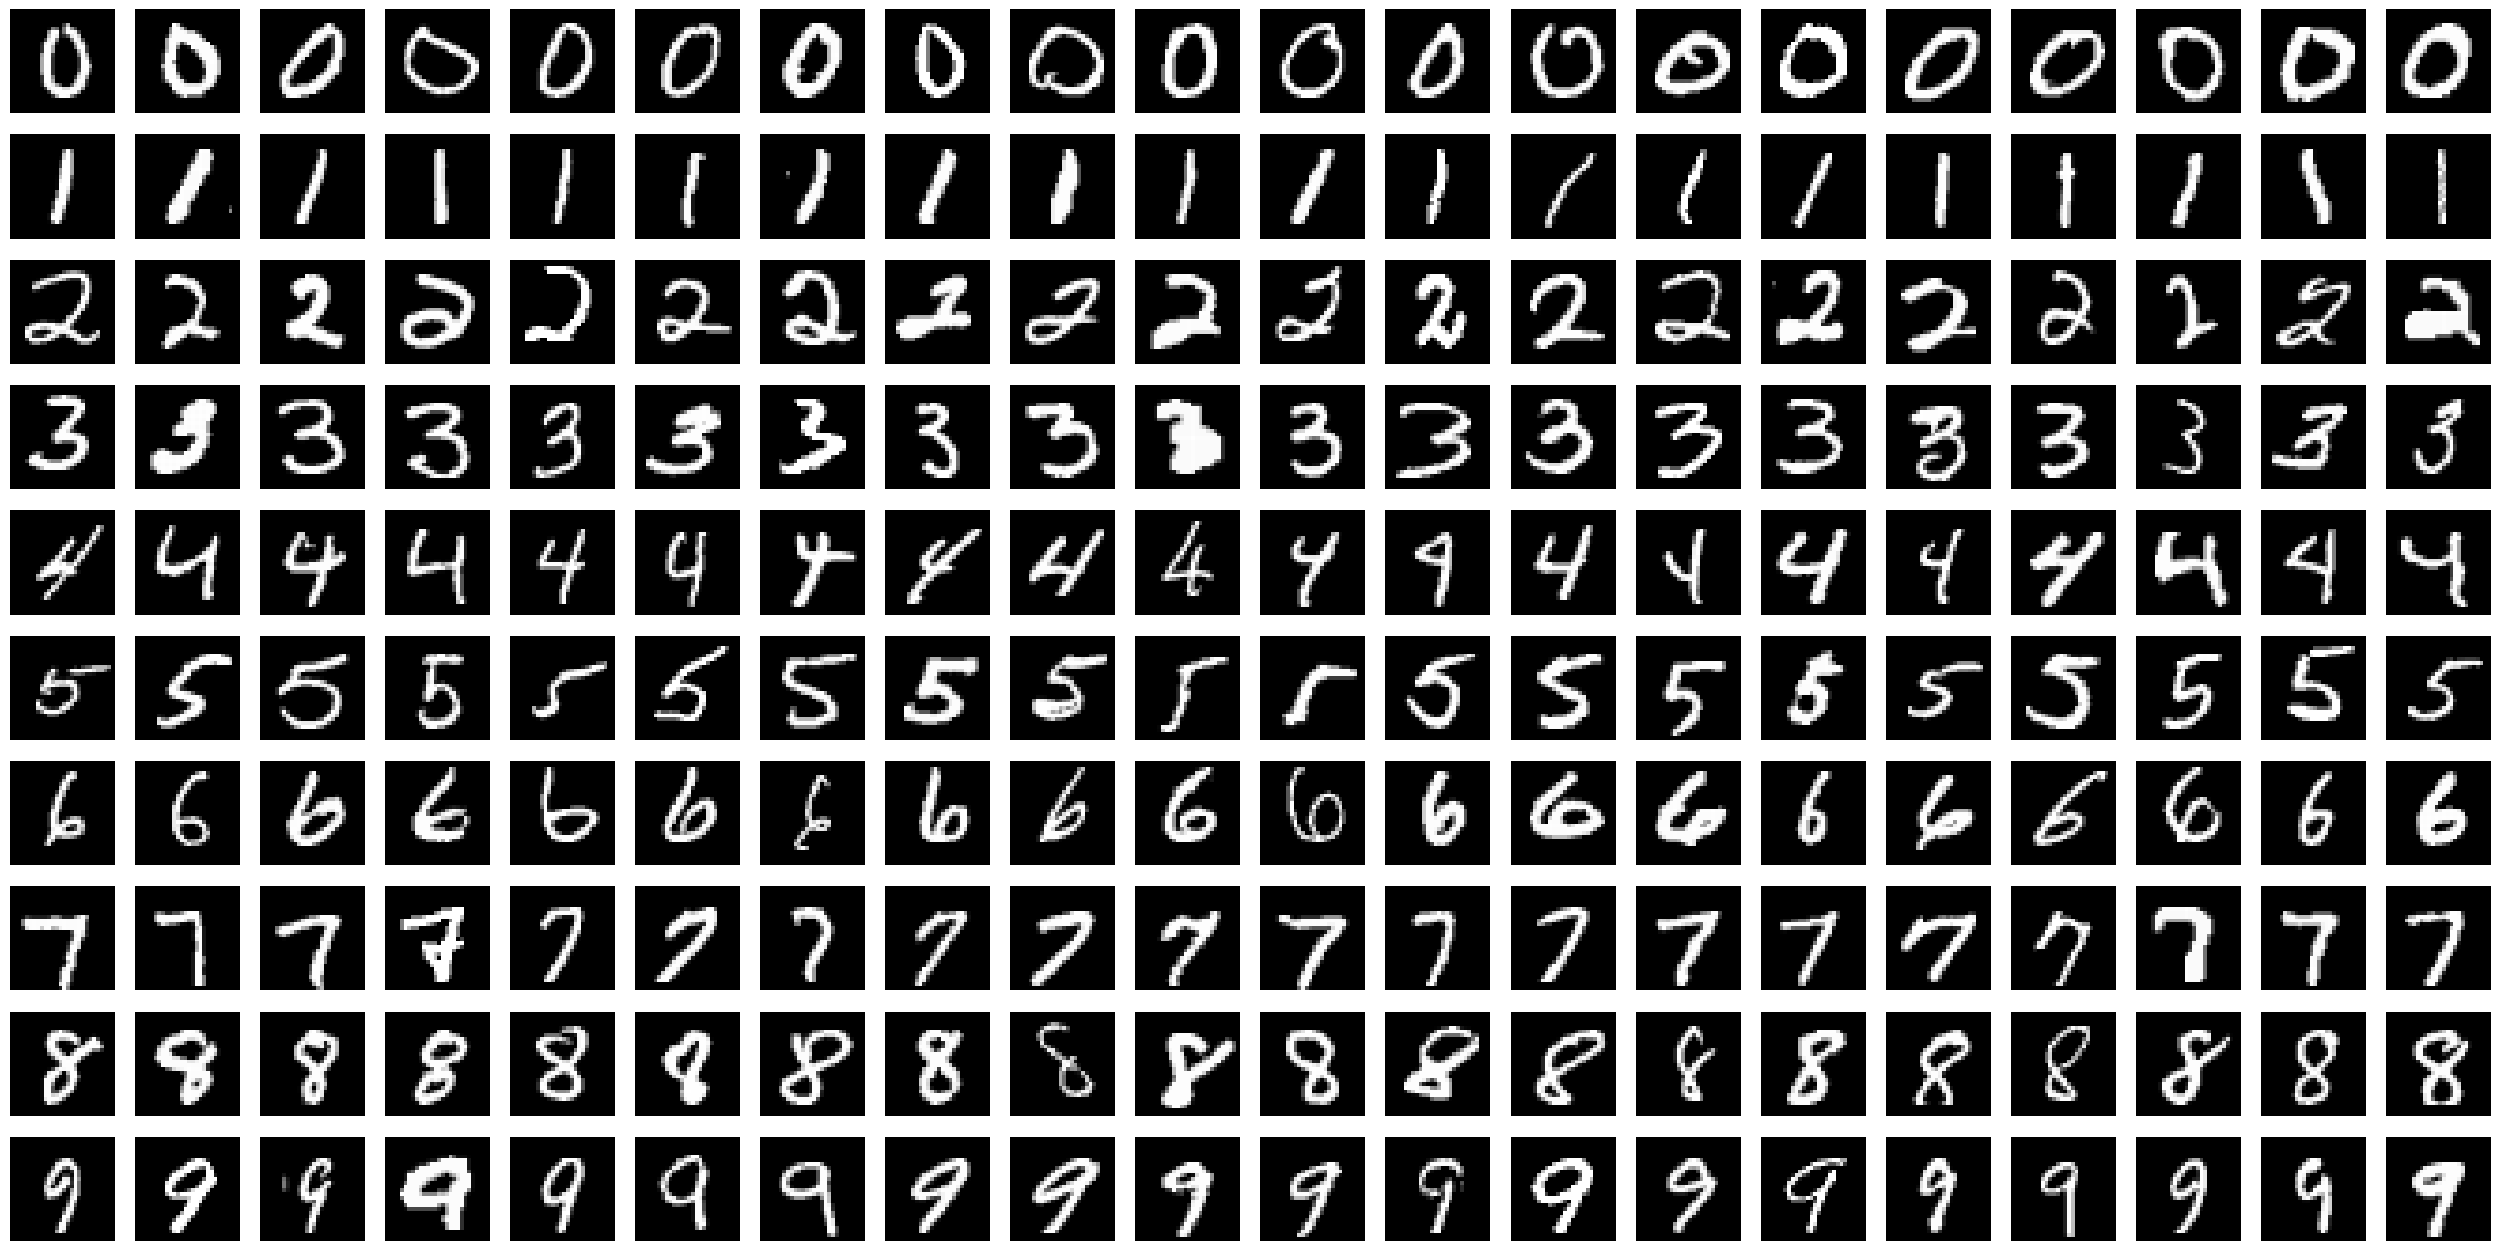

In [5]:
# Function to load images from a directory
def load_images_from_folder(folder, max_images=20):
    images = []
    for filename in os.listdir(folder)[:max_images]:
        img = Image.open(os.path.join(folder, filename))
        if img is not None:
            images.append(img)
    return images

P_digit = []
original_data = []

for digit in range(10):
    class_folder = os.path.join(save_dir, str(digit))
    images = load_images_from_folder(class_folder, max_images=train_size)

    P = []
    for k in range(len(images)):
        img = images[k]
        img = img.resize((28, 28))
        original_data.append(np.asarray(img))
        array_obj = np.asarray(img).reshape(S)
        P.append(array_obj)

    P_digit.append(np.array(P))

# Load and display images horizontally for each class
plt.figure(figsize=(32, 16))
for digit in range(10):
    for i in range(plot_num):
        plt.subplot(10, plot_num, digit * plot_num + i + 1)
        plt.imshow(P_digit[digit][i].reshape((28,28)), cmap='gray', vmin=0, vmax=255)
        plt.axis('off')  # Hide axes

plt.show()

### Build Dataloader for Later

In [59]:
# Define a custom Dataset class
class CustomDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        """
        Args:
            data (numpy array): NumPy array of shape (num, 28*28)
            labels (numpy array): Corresponding labels for each image
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Get the image and label for a given index
        image = self.data[idx].reshape(28, 28).astype(np.float32) / 255.0 # Reshape from 28*28 to 28x28
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

train_data_original = np.array(original_data)
labels = np.repeat(np.arange(10), train_size)
custom_train_dataset = CustomDataset(train_data_original, labels, transform=transforms.ToTensor())
train_loader_original = DataLoader(dataset=custom_train_dataset, batch_size=64, shuffle=True)

## Direct Fitting

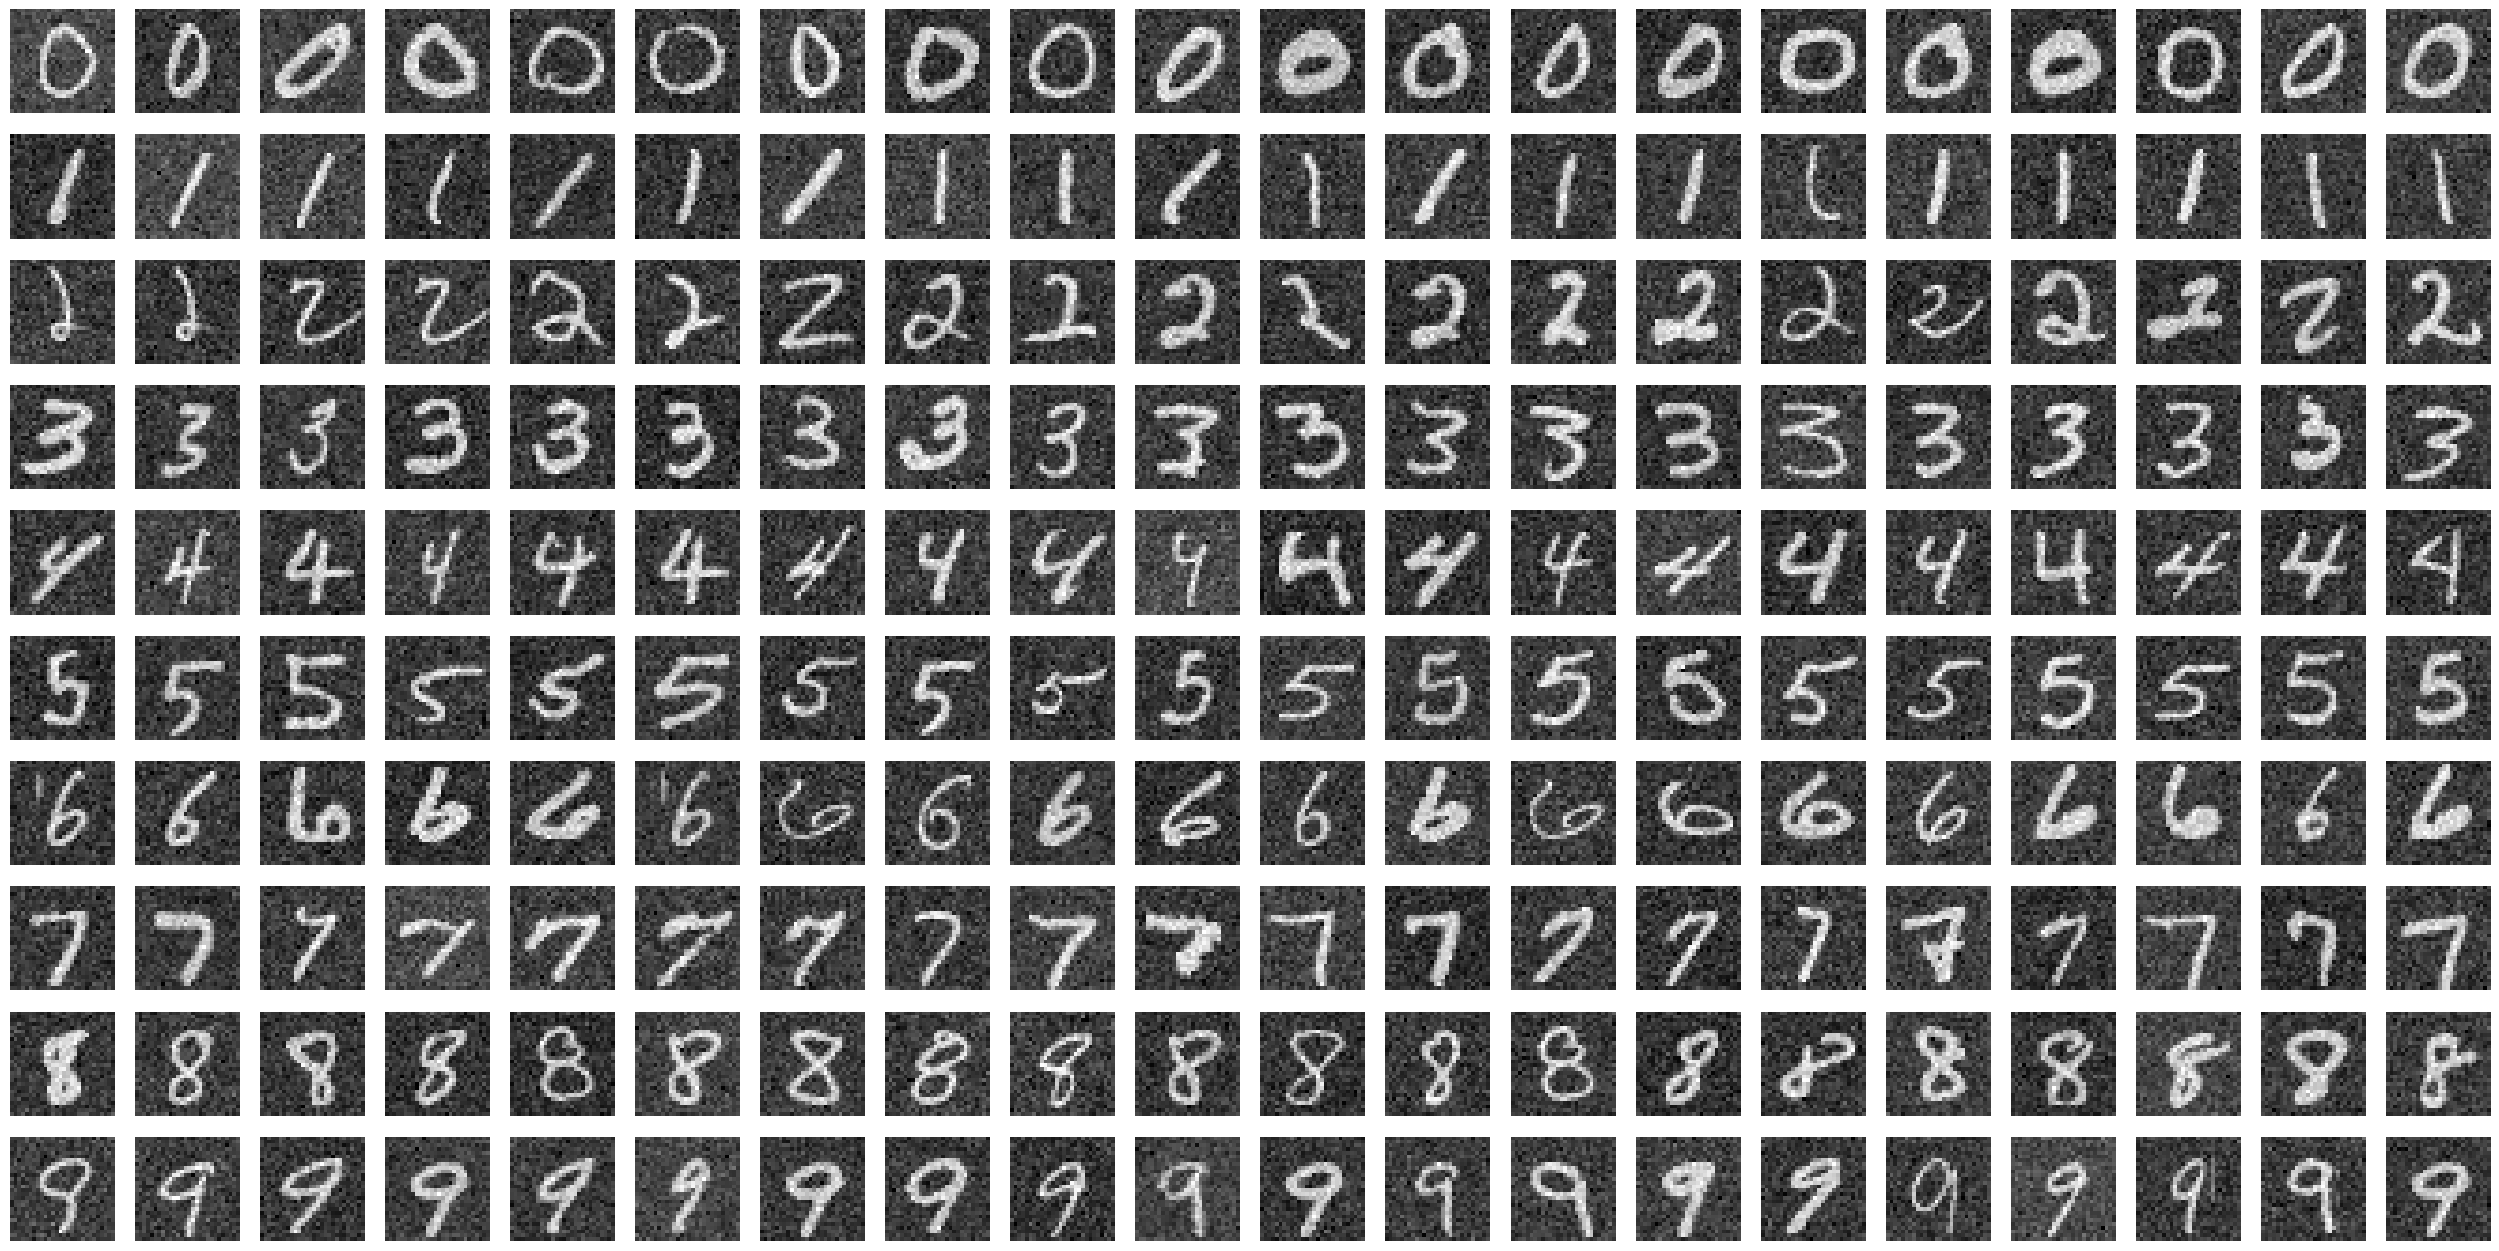

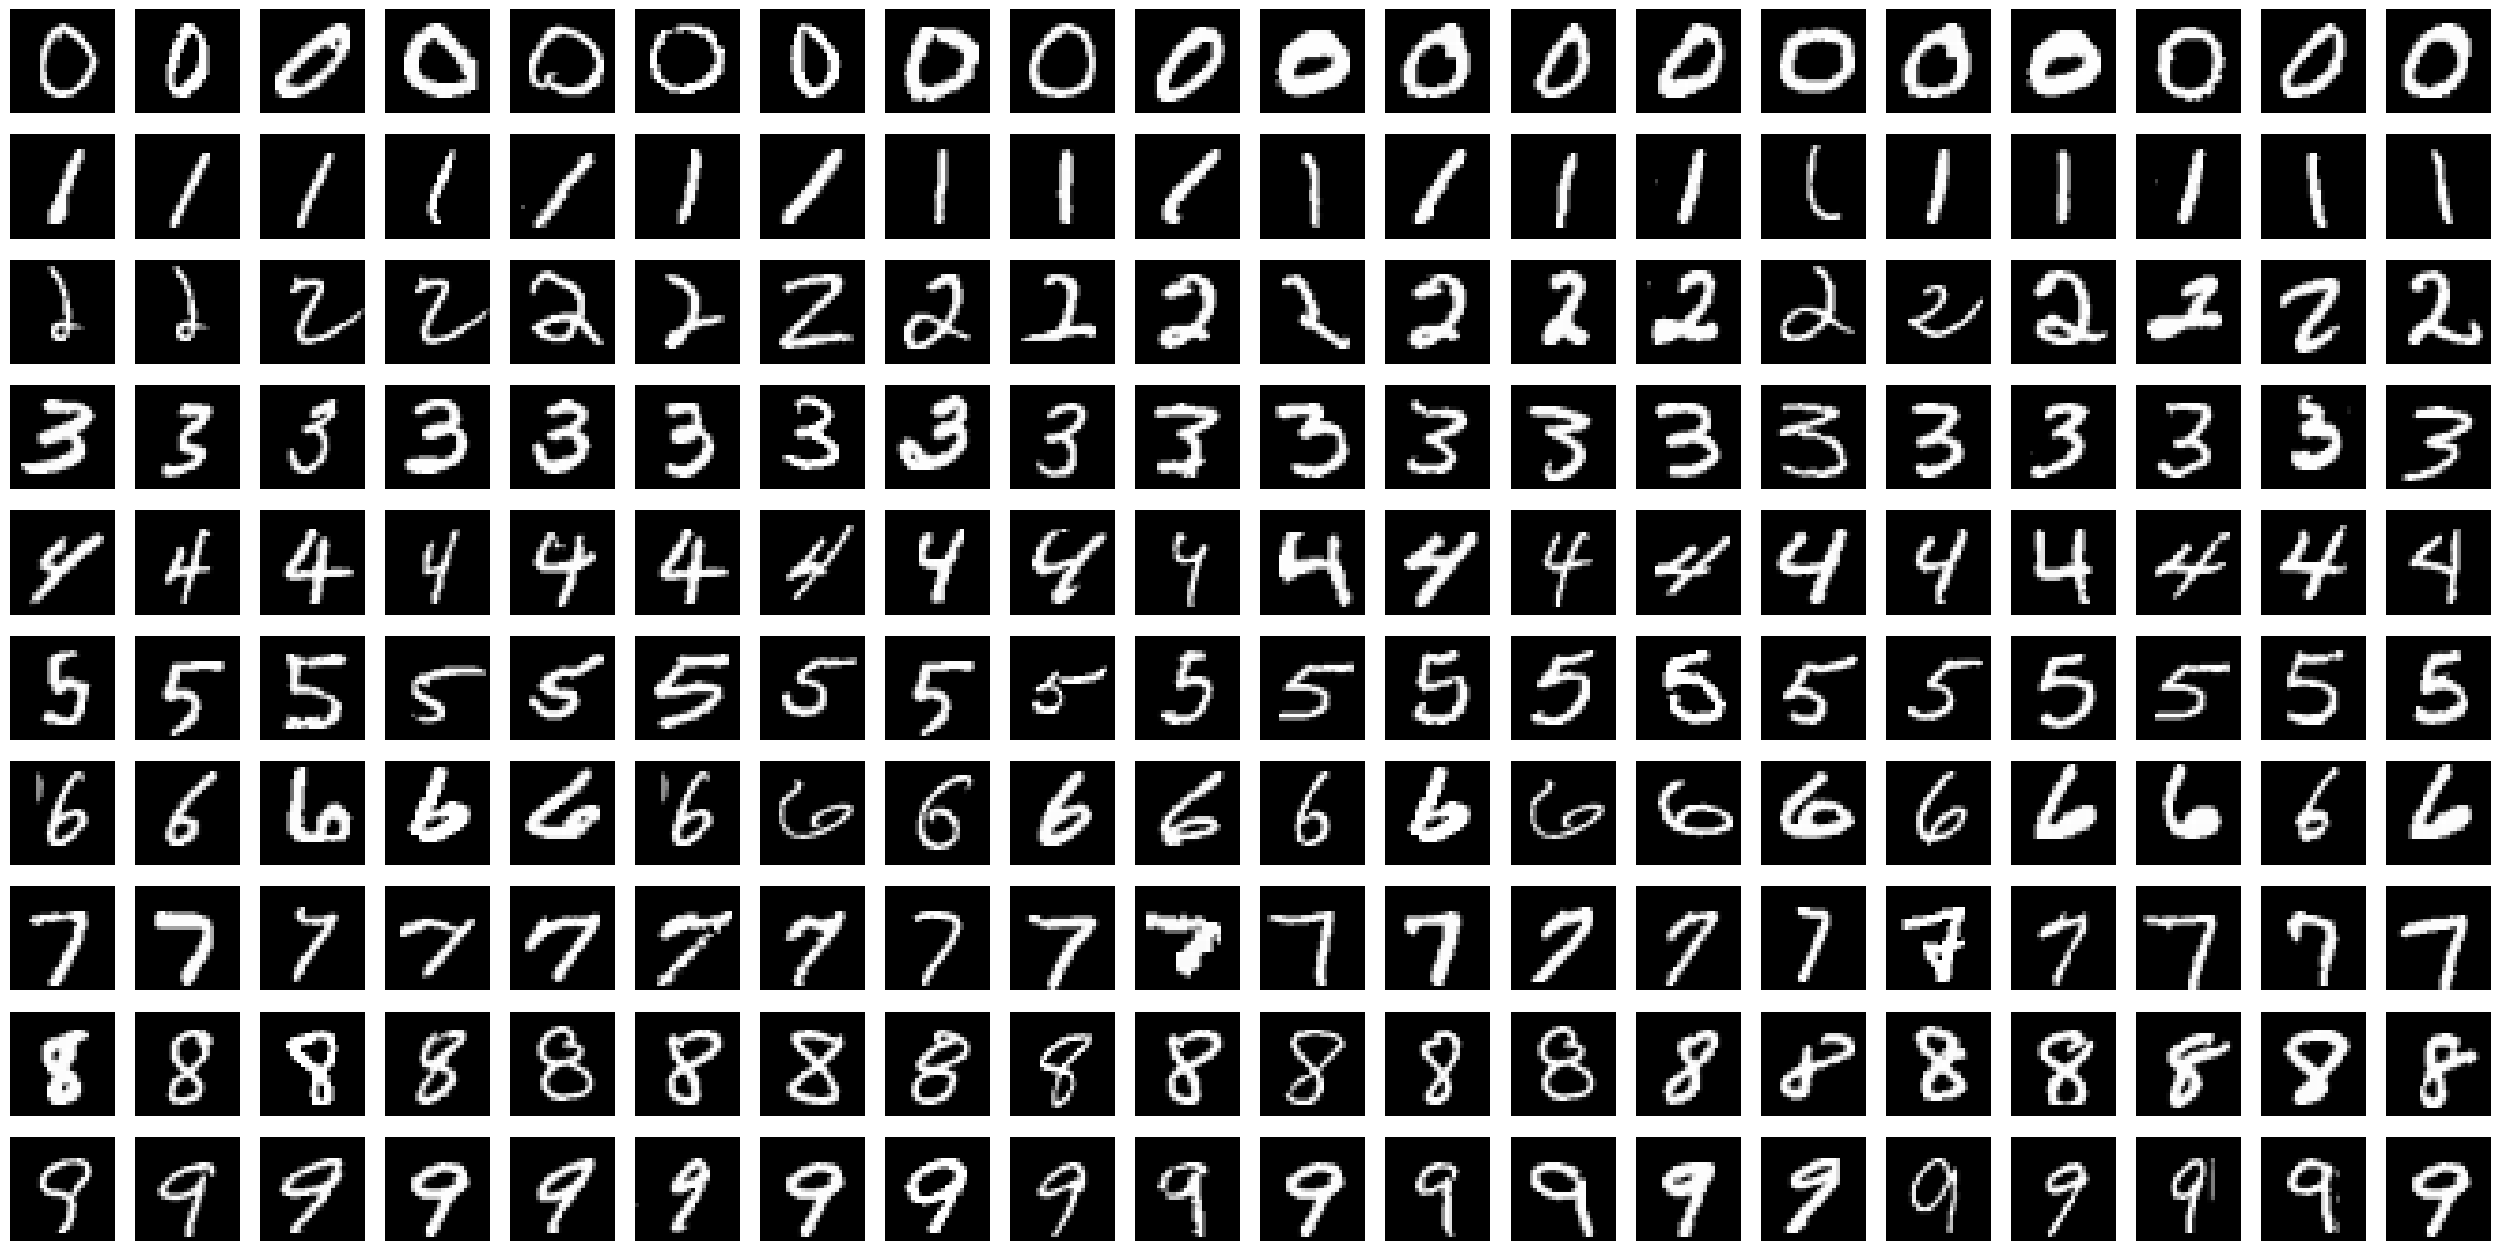

In [7]:
B_LD = ld.default_B(S, len(S), cp.get_array_module(P[0])) # Full Basis (direct fitting essentially)

num_new_samples = 20

sampled_P_digit = []

for digit in range(10):
    reduced_P = vectorize_tensor(P_digit[digit], B_LD)

    # Fit a KDE to the theta values
    kde = KernelDensity(kernel='gaussian', bandwidth=30).fit(reduced_P)

    # Sample new data from the KDE
    sampled_reduced_P = kde.sample(n_samples=num_new_samples)

    sampled_P = reconstruct_tensor(sampled_reduced_P, (num_new_samples, *S), B_LD)
    sampled_P_digit.append(sampled_P)

plt.figure(figsize=(32, 16))
for digit in range(10):
    for i in range(plot_num):
        plt.subplot(10, plot_num, digit * plot_num + i + 1)
        plt.imshow(sampled_P_digit[digit][i].reshape((28, 28)), cmap='gray')
        plt.axis('off')  # Hide axes

# Find the nearest distance between every new sample among the training set in terms of norm.
plt.figure(figsize=(32, 16))
for digit in range(10):
    for i in range(plot_num):
        norm = [np.linalg.norm(sampled_P_digit[digit][i].reshape((28, 28)) - p.reshape((28, 28))) for p in P_digit[digit]]
        idx = np.argmin(norm)
        plt.subplot(10, plot_num, digit * plot_num + i + 1)
        plt.imshow(P_digit[digit][idx].reshape((28, 28)), cmap='gray', vmin=0, vmax=255) # [0, 255]
        plt.axis('off')  # Hide axes

plt.show()

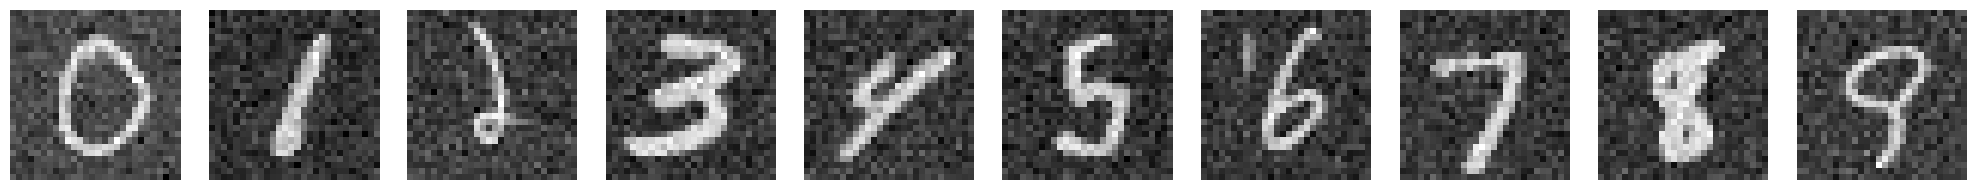

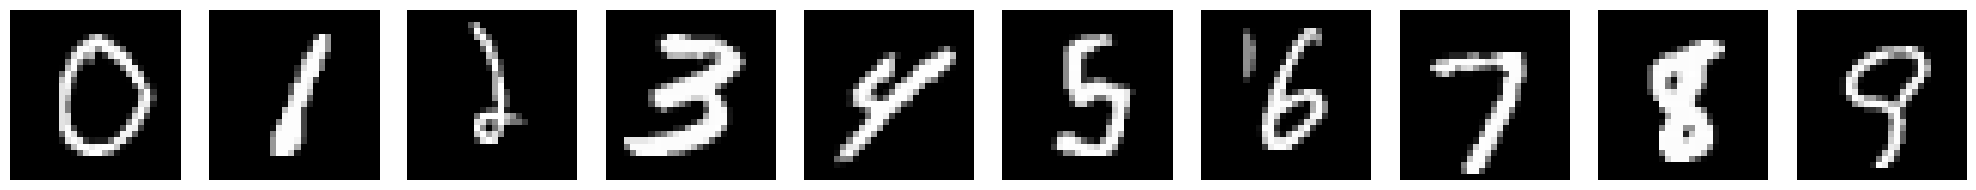

In [124]:
plt.figure(figsize=(20, 2))
for digit in range(10):
    for i in range(paper_plot_num):
        plt.subplot(paper_plot_num, 10, digit * paper_plot_num + i + 1)
        plt.imshow(sampled_P_digit[digit][i].reshape((28, 28)), cmap='gray')
        plt.axis('off')  # Hide axes

plt.tight_layout()

plt.savefig('../Figures/MNIST_direct_fitting.png', format='png', dpi=300)

plt.show()

# Find the nearest distance between every new sample among the training set in terms of norm.
plt.figure(figsize=(20, 2))
for digit in range(10):
    for i in range(paper_plot_num):
        norm = [np.linalg.norm(sampled_P_digit[digit][i].reshape((28, 28)) - p.reshape((28, 28))) for p in P_digit[digit]]
        idx = np.argmin(norm)
        plt.subplot(paper_plot_num, 10, digit * paper_plot_num + i + 1)
        plt.imshow(P_digit[digit][idx].reshape((28, 28)), cmap='gray', vmin=0, vmax=255) # [0, 255]
        plt.axis('off')  # Hide axes

plt.tight_layout()

plt.savefig('../Figures/MNIST_direct_fitting_compare.png', format='png', dpi=300)

plt.show()

## Data Augmentation with Log-Linear Model

### Legendre Decomposition

In [8]:
B_LD = ld.default_B(S, 2, cp.get_array_module(P[0]))

print(B_LD.shape)

def helper(i, digit):
    _, _, scaleX, Q, theta = ld.LD(P_digit[digit][i], B=B_LD, verbose=False, n_iter=1000, lr=1e-1)
    return (scaleX, Q, theta)

results = Parallel(n_jobs=30)(delayed(helper)(i, digit) for i in range(train_size) for digit in range(10))

scaleX_digit = []
Q_digit = []
theta_digit = []
X_recons_digit = []

for digit in range(10):
    scaleX_list = []
    Q_list = []
    theta_list = []
    X_recons_list = []
    for i in range(train_size):
        result = results[i*10 + digit]

        scaleX_list.append(result[0])
        Q_list.append(result[1])
        theta_list.append(result[2])
        X_recons = (result[1] * result[0]).astype(np.int32)
        X_recons_list.append(X_recons)

    scaleX_digit.append(np.array(scaleX_list))
    Q_digit.append(np.array(Q_list))
    theta_digit.append(np.array(theta_list))
    X_recons_digit.append(np.array(X_recons_list))

(107, 6)


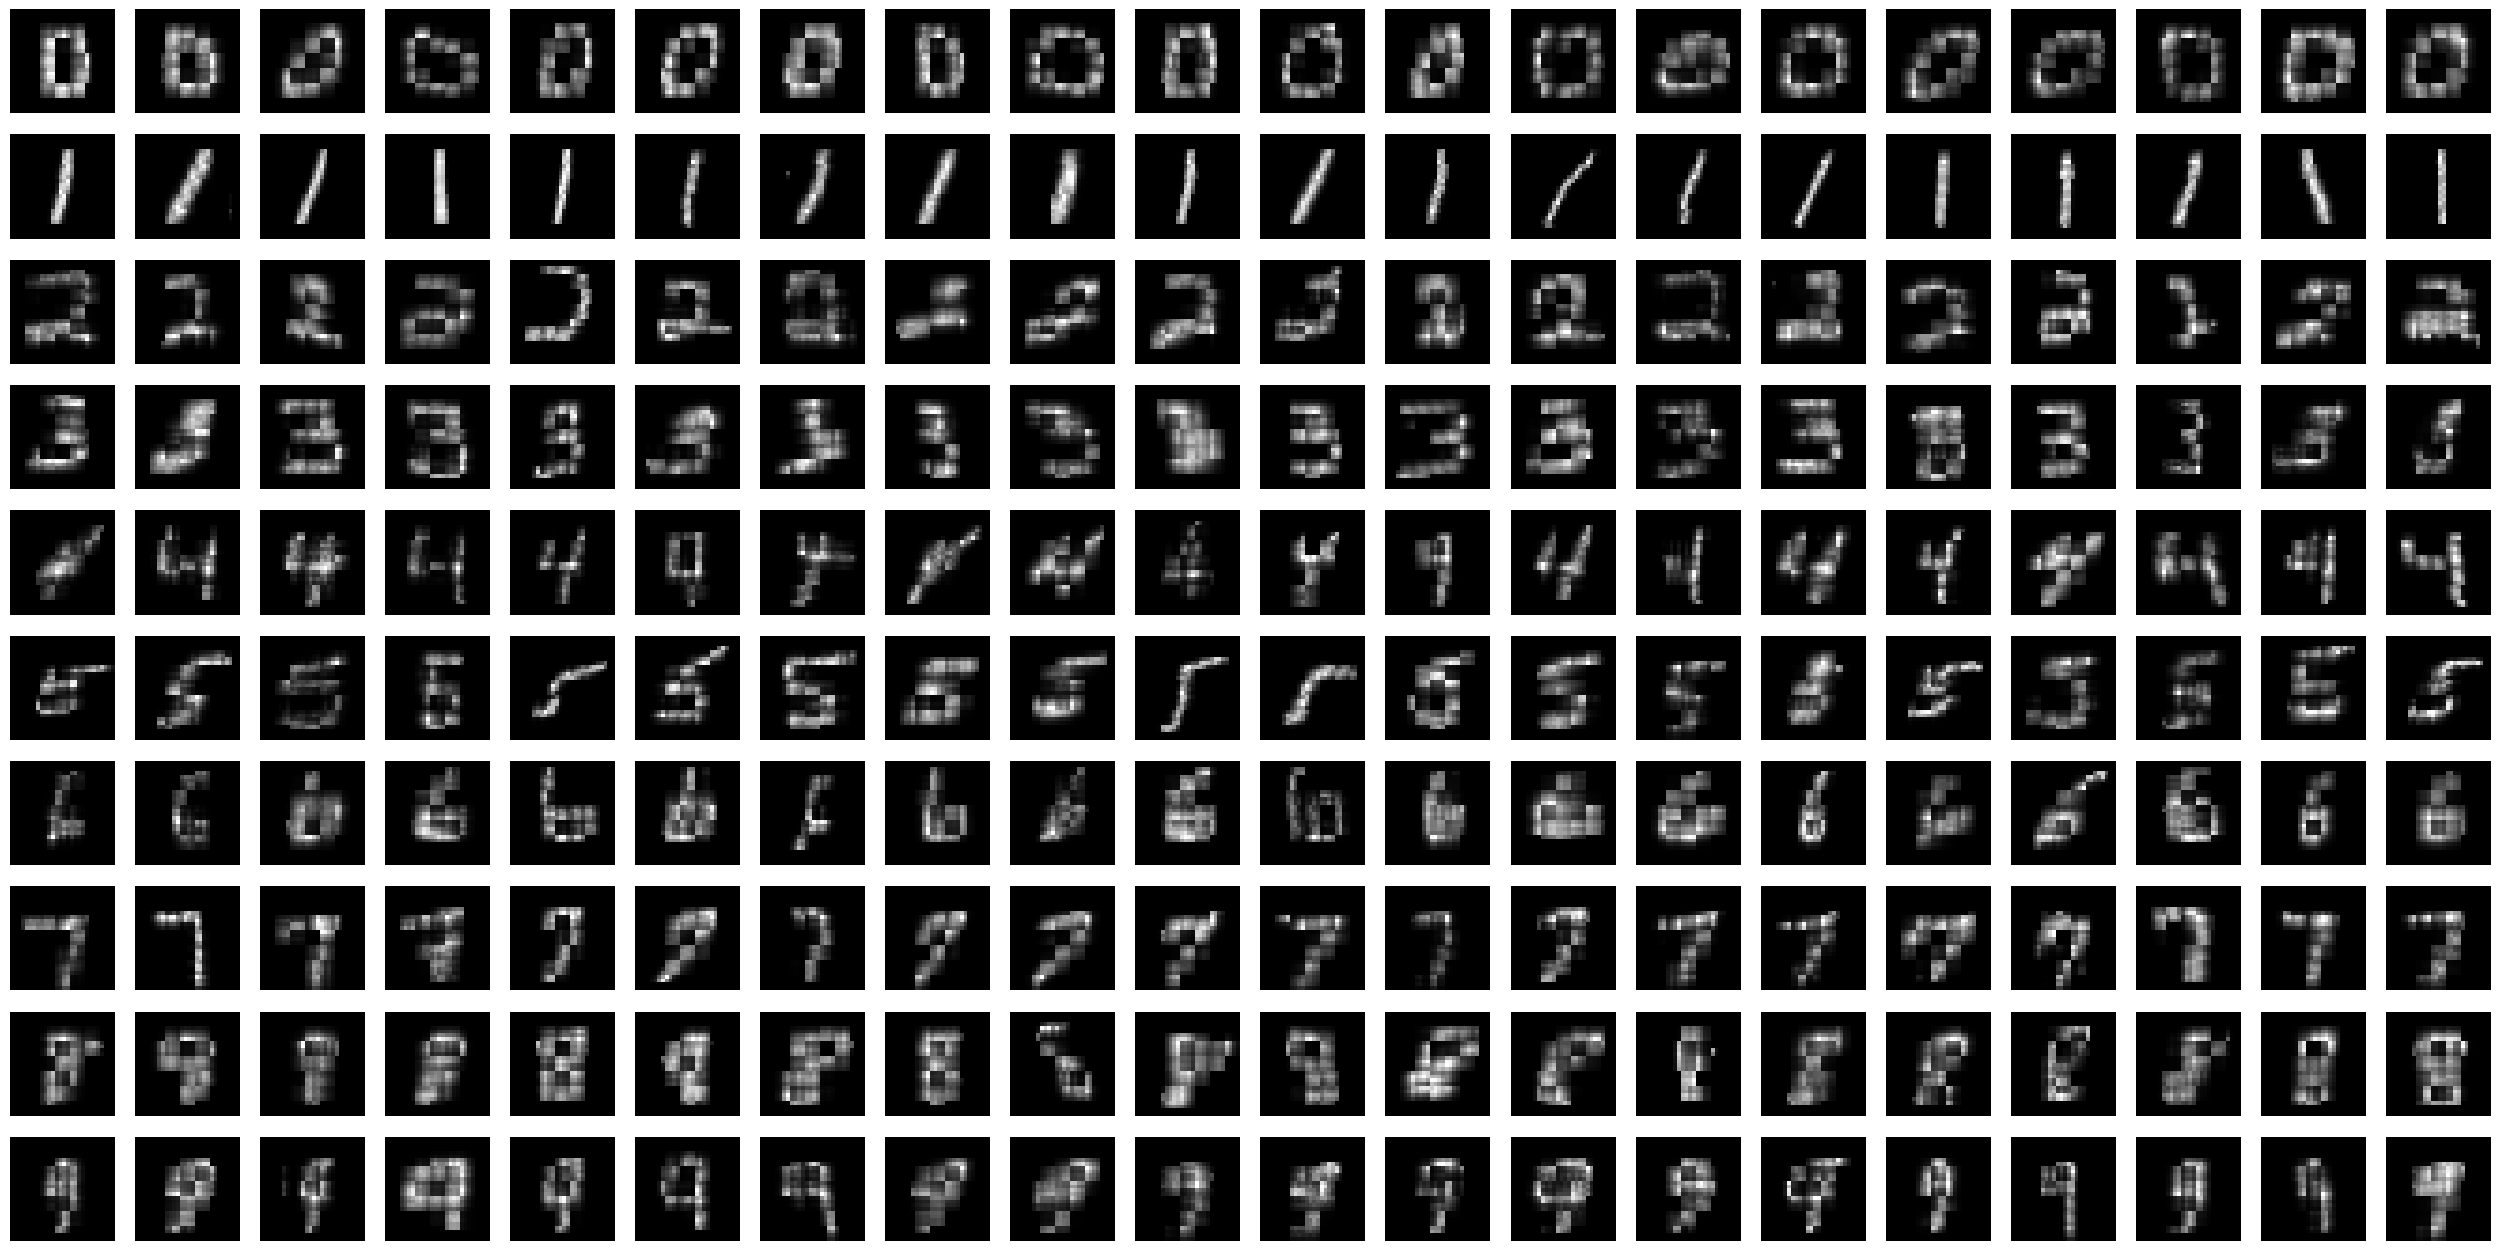

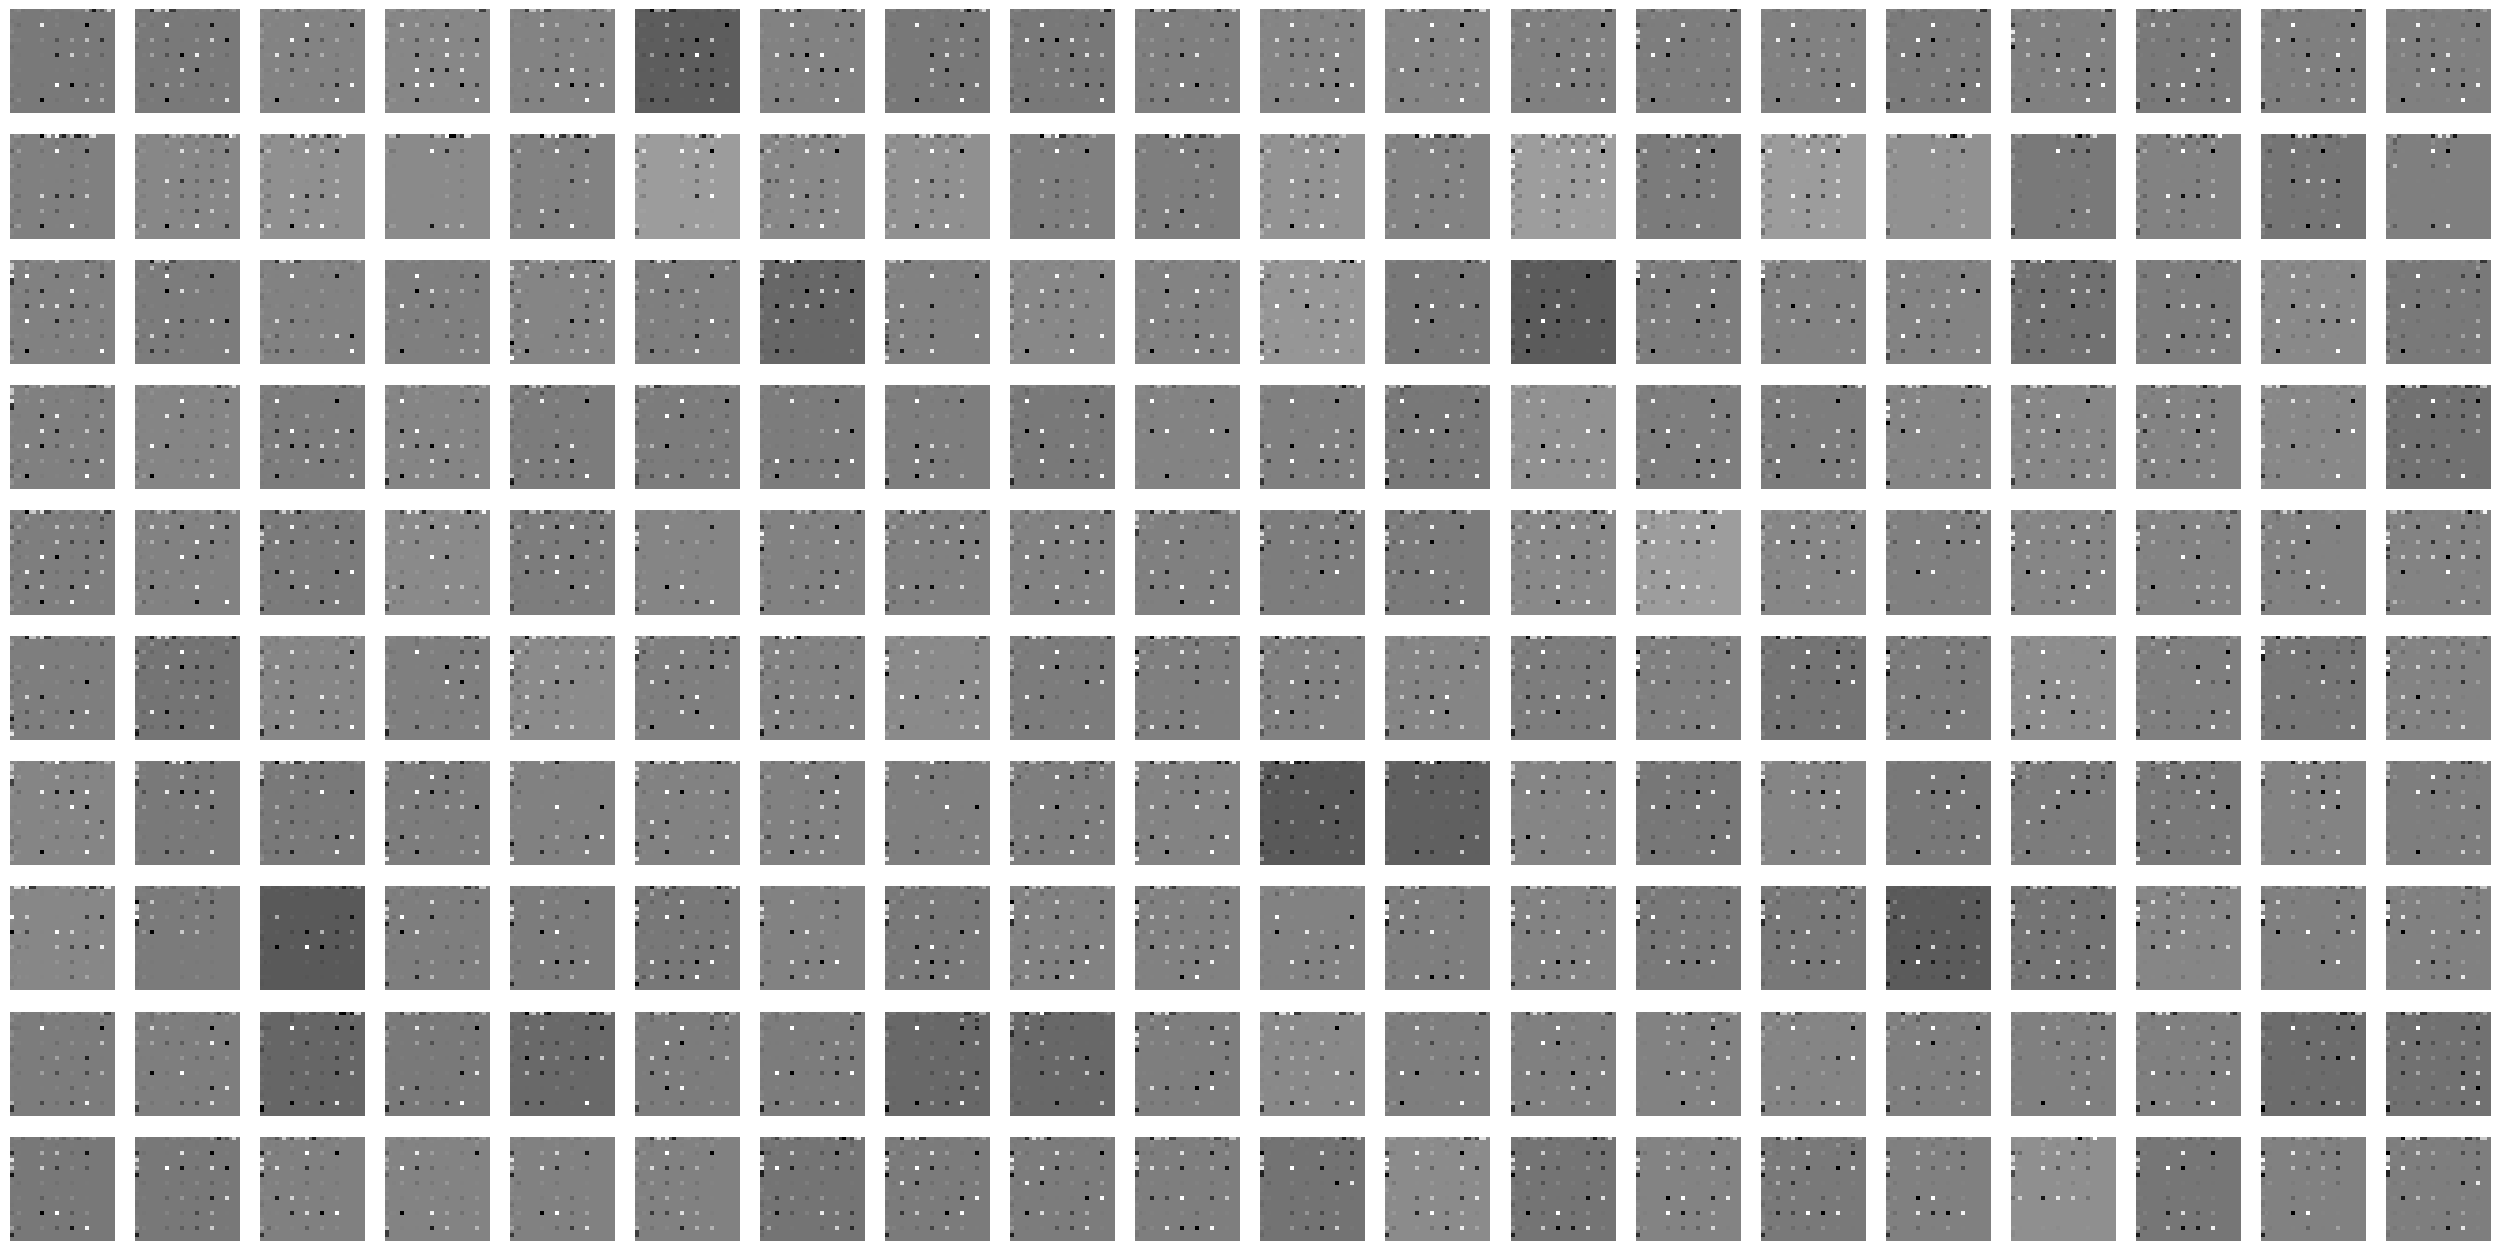

In [9]:
# Load and display images horizontally for each class
plt.figure(figsize=(32, 16))
for digit in range(10):
    for i in range(plot_num):
        plt.subplot(10, plot_num, digit * plot_num + i + 1)
        plt.imshow(renormalize_image(X_recons_digit[digit][i]).reshape((28, 28)), cmap='gray', vmin=0, vmax=255)
        plt.axis('off')  # Hide axes

plt.show()

plt.figure(figsize=(32, 16))
for digit in range(10):
    for i in range(plot_num):
        plt.subplot(10, plot_num, digit * plot_num + i + 1)
        plt.imshow(theta_digit[digit][i].reshape((28, 28)), cmap='gray')
        plt.axis('off')  # Hide axes

plt.show()

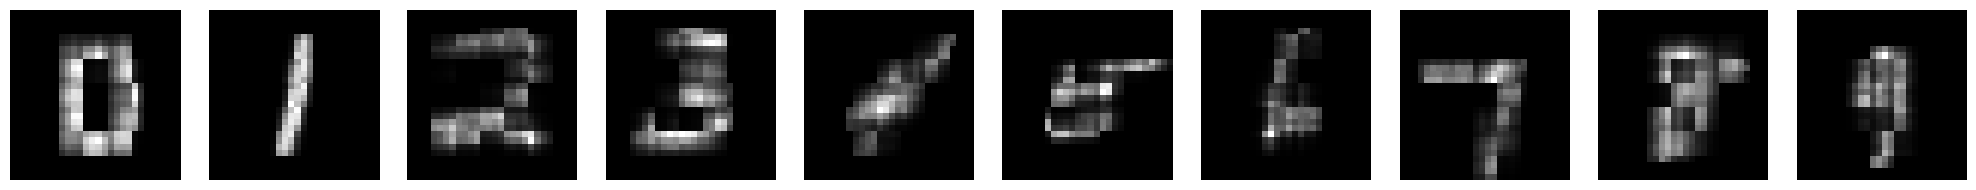

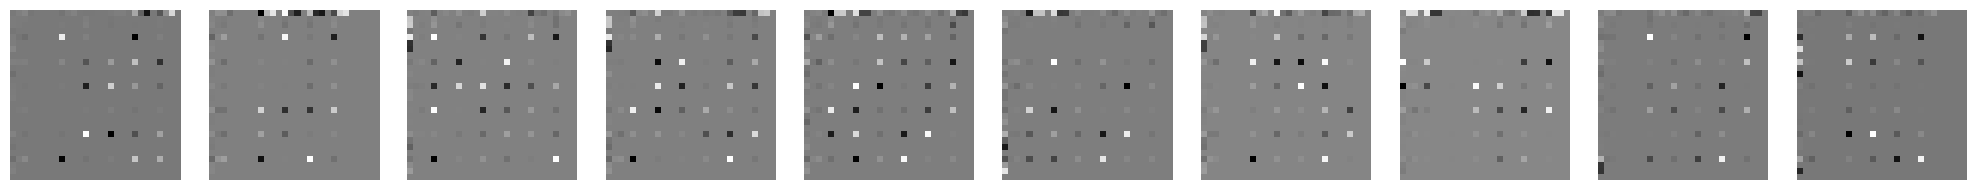

In [125]:
plt.figure(figsize=(20, 2))
for digit in range(10):
    for i in range(paper_plot_num):
        plt.subplot(paper_plot_num, 10, digit * paper_plot_num + i + 1)
        plt.imshow(renormalize_image(X_recons_digit[digit][i]).reshape((28, 28)), cmap='gray', vmin=0, vmax=255)
        plt.axis('off')  # Hide axes

plt.tight_layout()

plt.savefig('../Figures/MNIST_LD_2_body.png', format='png', dpi=300)

plt.show()

# Find the nearest distance between every new sample among the training set in terms of norm.
plt.figure(figsize=(20, 2))
for digit in range(10):
    for i in range(paper_plot_num):
        plt.subplot(paper_plot_num, 10, digit * paper_plot_num + i + 1)
        plt.imshow(theta_digit[digit][i].reshape((28, 28)), cmap='gray')
        plt.axis('off')  # Hide axes

plt.tight_layout()

plt.savefig('../Figures/MNIST_LD_2_body_parameter.png', format='png', dpi=300)

plt.show()

#### Fitting on Projected Points

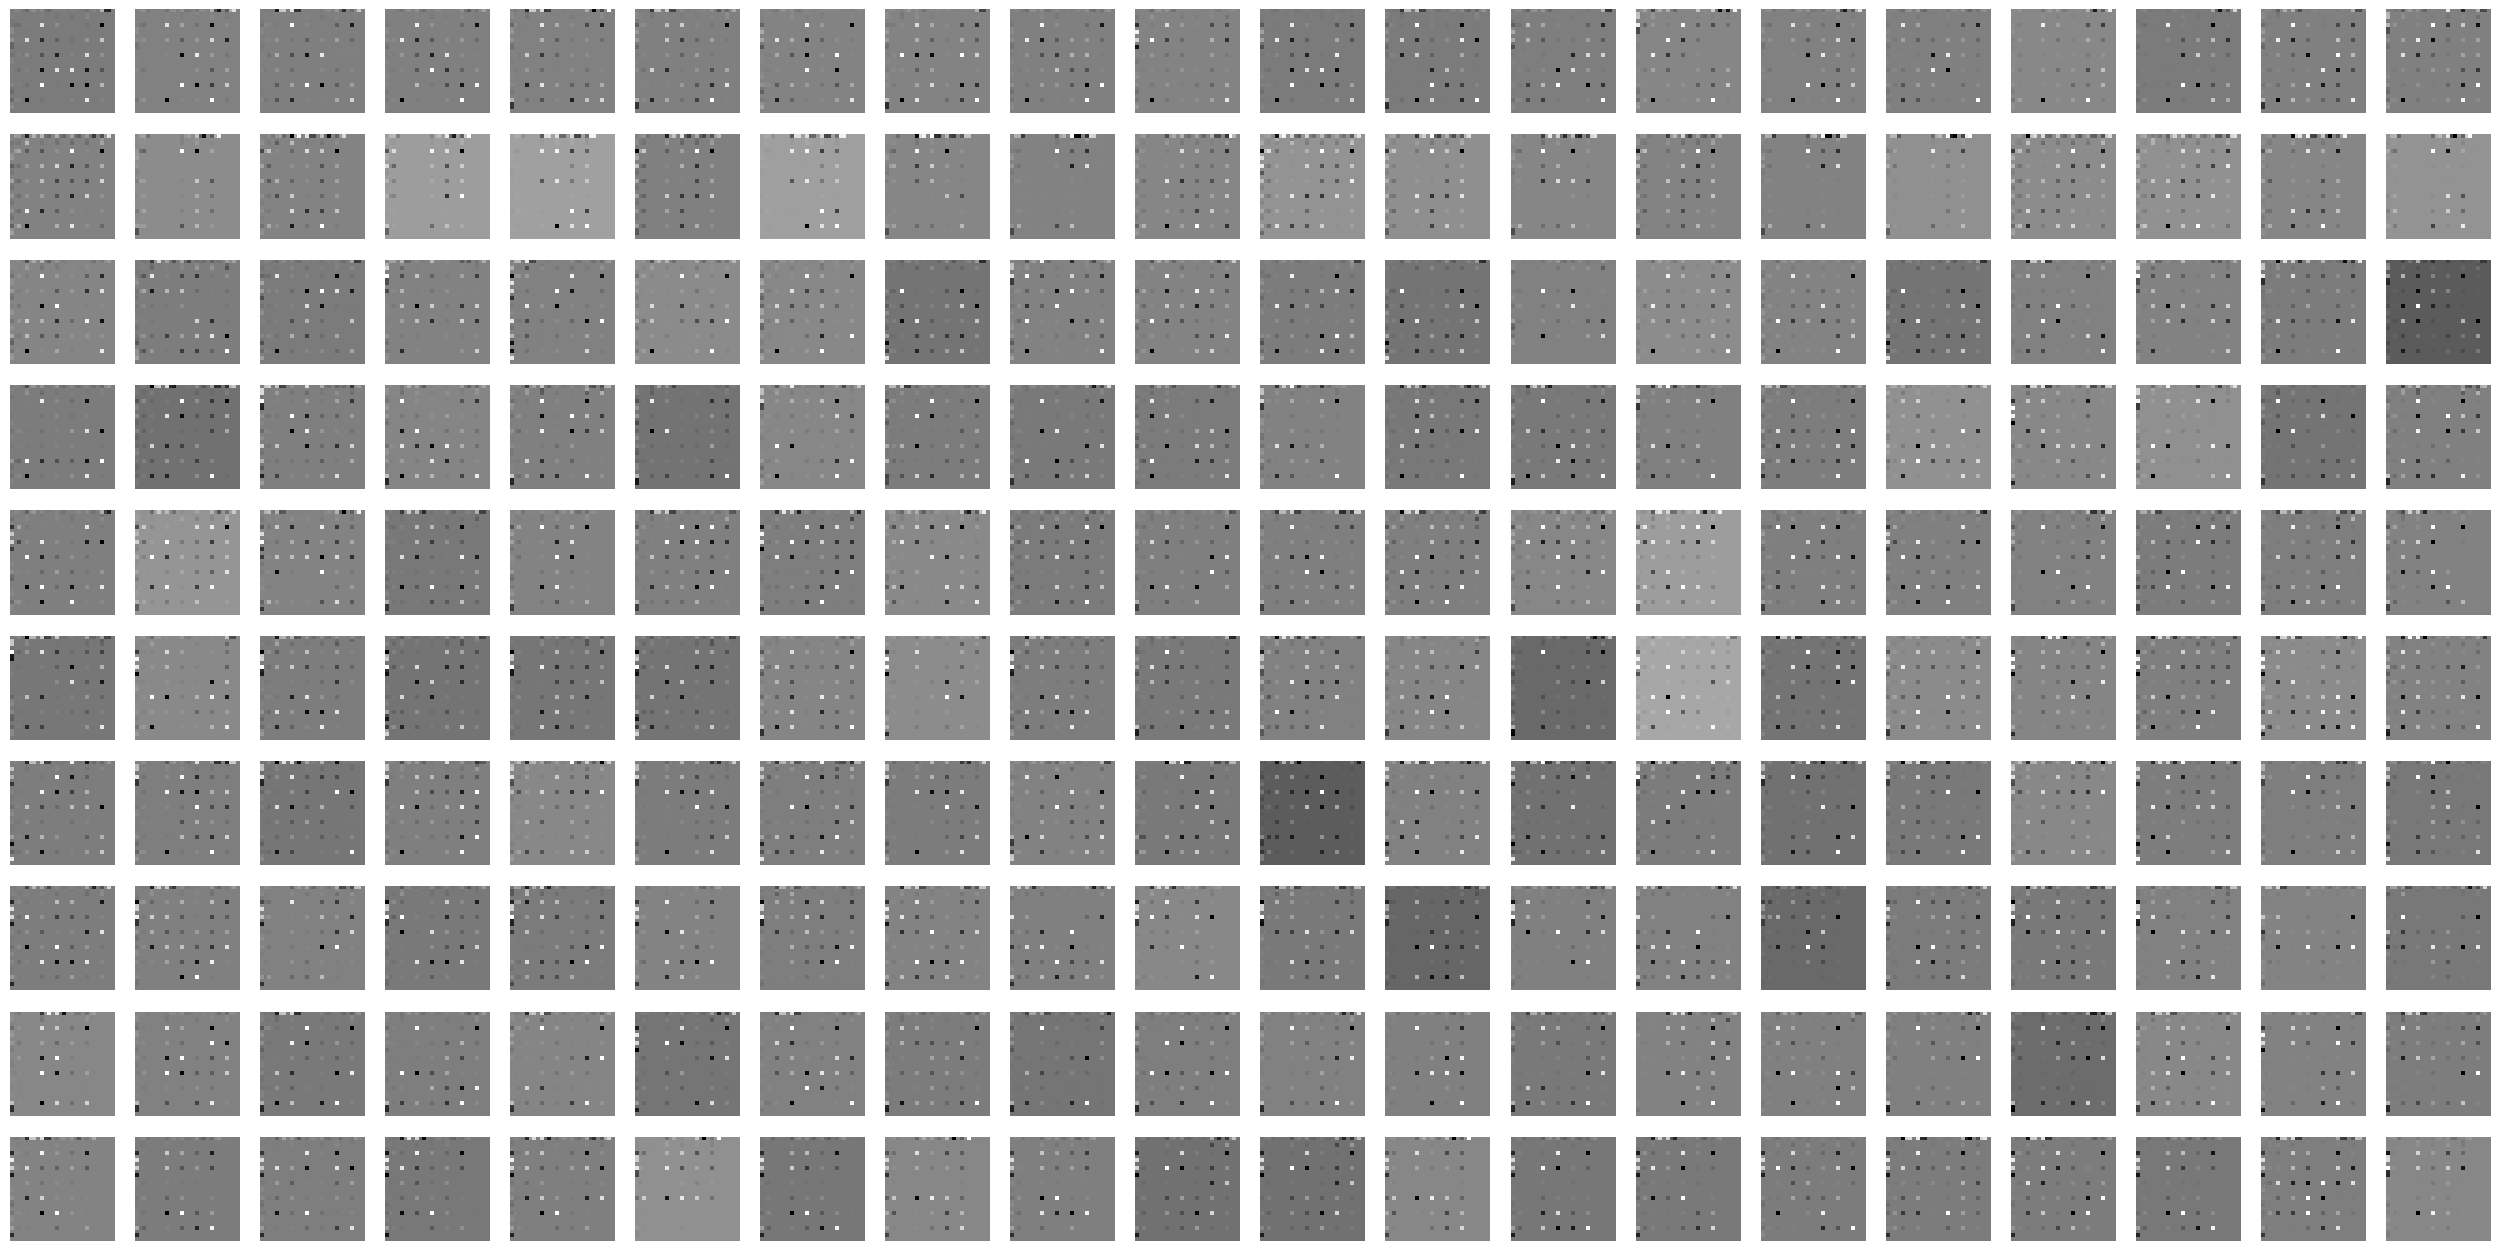

In [10]:
num_new_samples = 20

sampled_theta_digit = []

for digit in range(10):
    reduced_theta = vectorize_tensor(theta_digit[digit], B_LD)

    # Fit a KDE to the theta values
    kde = KernelDensity(kernel='gaussian', bandwidth=0.05).fit(reduced_theta)
    # Sample new data from the KDE
    sampled_reduced_theta = kde.sample(n_samples=num_new_samples)

    sampled_theta = reconstruct_tensor(sampled_reduced_theta, (num_new_samples, *S), B_LD)
    sampled_theta_digit.append(sampled_theta)

plt.figure(figsize=(32, 16))
for digit in range(10):
    for i in range(plot_num):
        plt.subplot(10, plot_num, digit * plot_num + i + 1)
        plt.imshow(sampled_theta_digit[digit][i].reshape((28, 28)), cmap='gray')
        plt.axis('off')  # Hide axes

plt.show()

#### Construct Local Sub-Manifold

In [129]:
# Construct the constrained coordinates
# B_BP = ld.block_B([14, 14], [15, 15])
B_BP = ld.default_B(S, 1, cp.get_array_module(P[0]))

print(B_BP.shape)

# Compute every datapoint's eta_hat (served as the linear constraints)
eta_hat_digit = []

for digit in range(10):
    eta_hat_list = []
    for i in range(P_digit[digit].shape[0]):
        xp = cp.get_array_module(P_digit[digit][i])
        P = (P_digit[digit][i] + eps) / scaleX_digit[digit][i]
        eta_hat = ld.get_eta(P, len(S), xp)
        eta_hat_list.append(eta_hat)

    eta_hat_digit.append(cp.asarray(eta_hat_list))

(17, 6)


#### Backward Projection

In [12]:
sampled_P_BP_digit = []
sampled_theta_BP_digit = []
sampled_X_recons_digit = []

for digit in range(10):
    sampled_P_BP = []
    sampled_theta_BP = []
    sampled_X_recons = []

    for i in range(num_new_samples):
        ks = ld.kNN(sampled_theta_digit[digit][i], theta_digit[digit], k=8)

        avg_scale = np.mean(scaleX_digit[digit][ks])
        avg_eta_hat = np.mean(eta_hat_digit[digit][ks], axis=0)

        history_kl, history_norm, P, theta = ld.BP(sampled_theta_digit[digit][i], [(P_digit[digit][k] + eps) / scaleX_digit[digit][k] for k in ks], avg_eta_hat, avg_scale, B=B_BP, verbose=False, n_iter=1000, lr=1e-1)
        sampled_P_BP.append(P)
        sampled_theta_BP.append(theta)

        X_recons_ = (P).astype(np.int32)
        sampled_X_recons.append(X_recons_)

    sampled_P_BP_digit.append(np.array(sampled_P_BP))
    sampled_theta_BP_digit.append(np.array(sampled_theta_BP))
    sampled_X_recons_digit.append(np.array(sampled_X_recons))

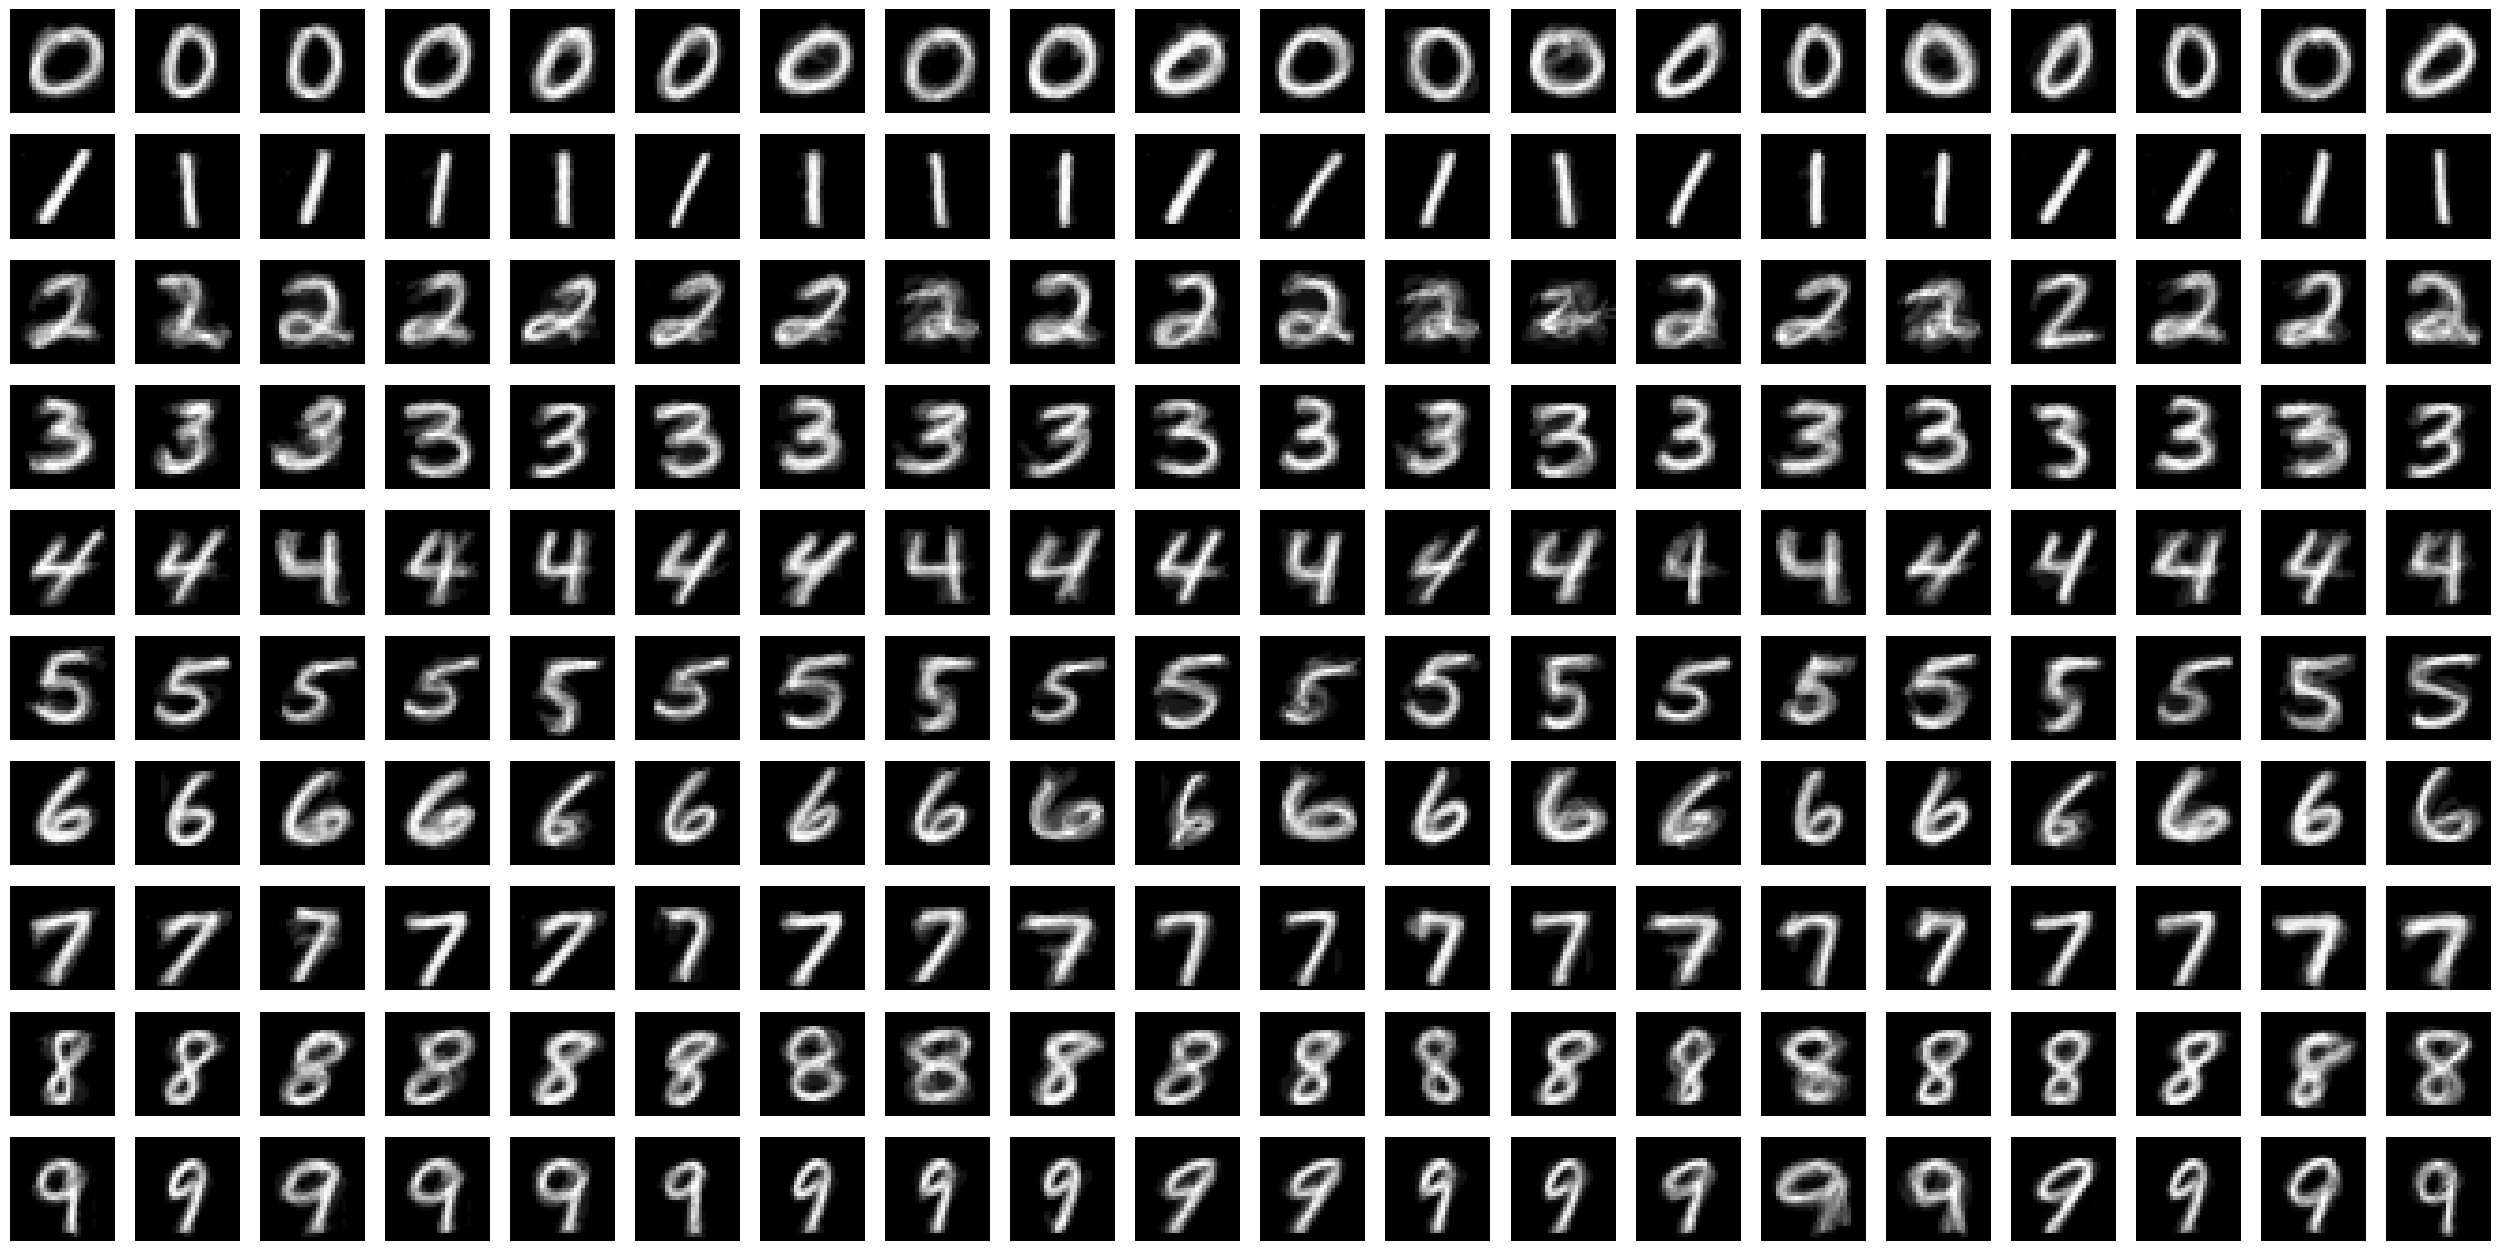

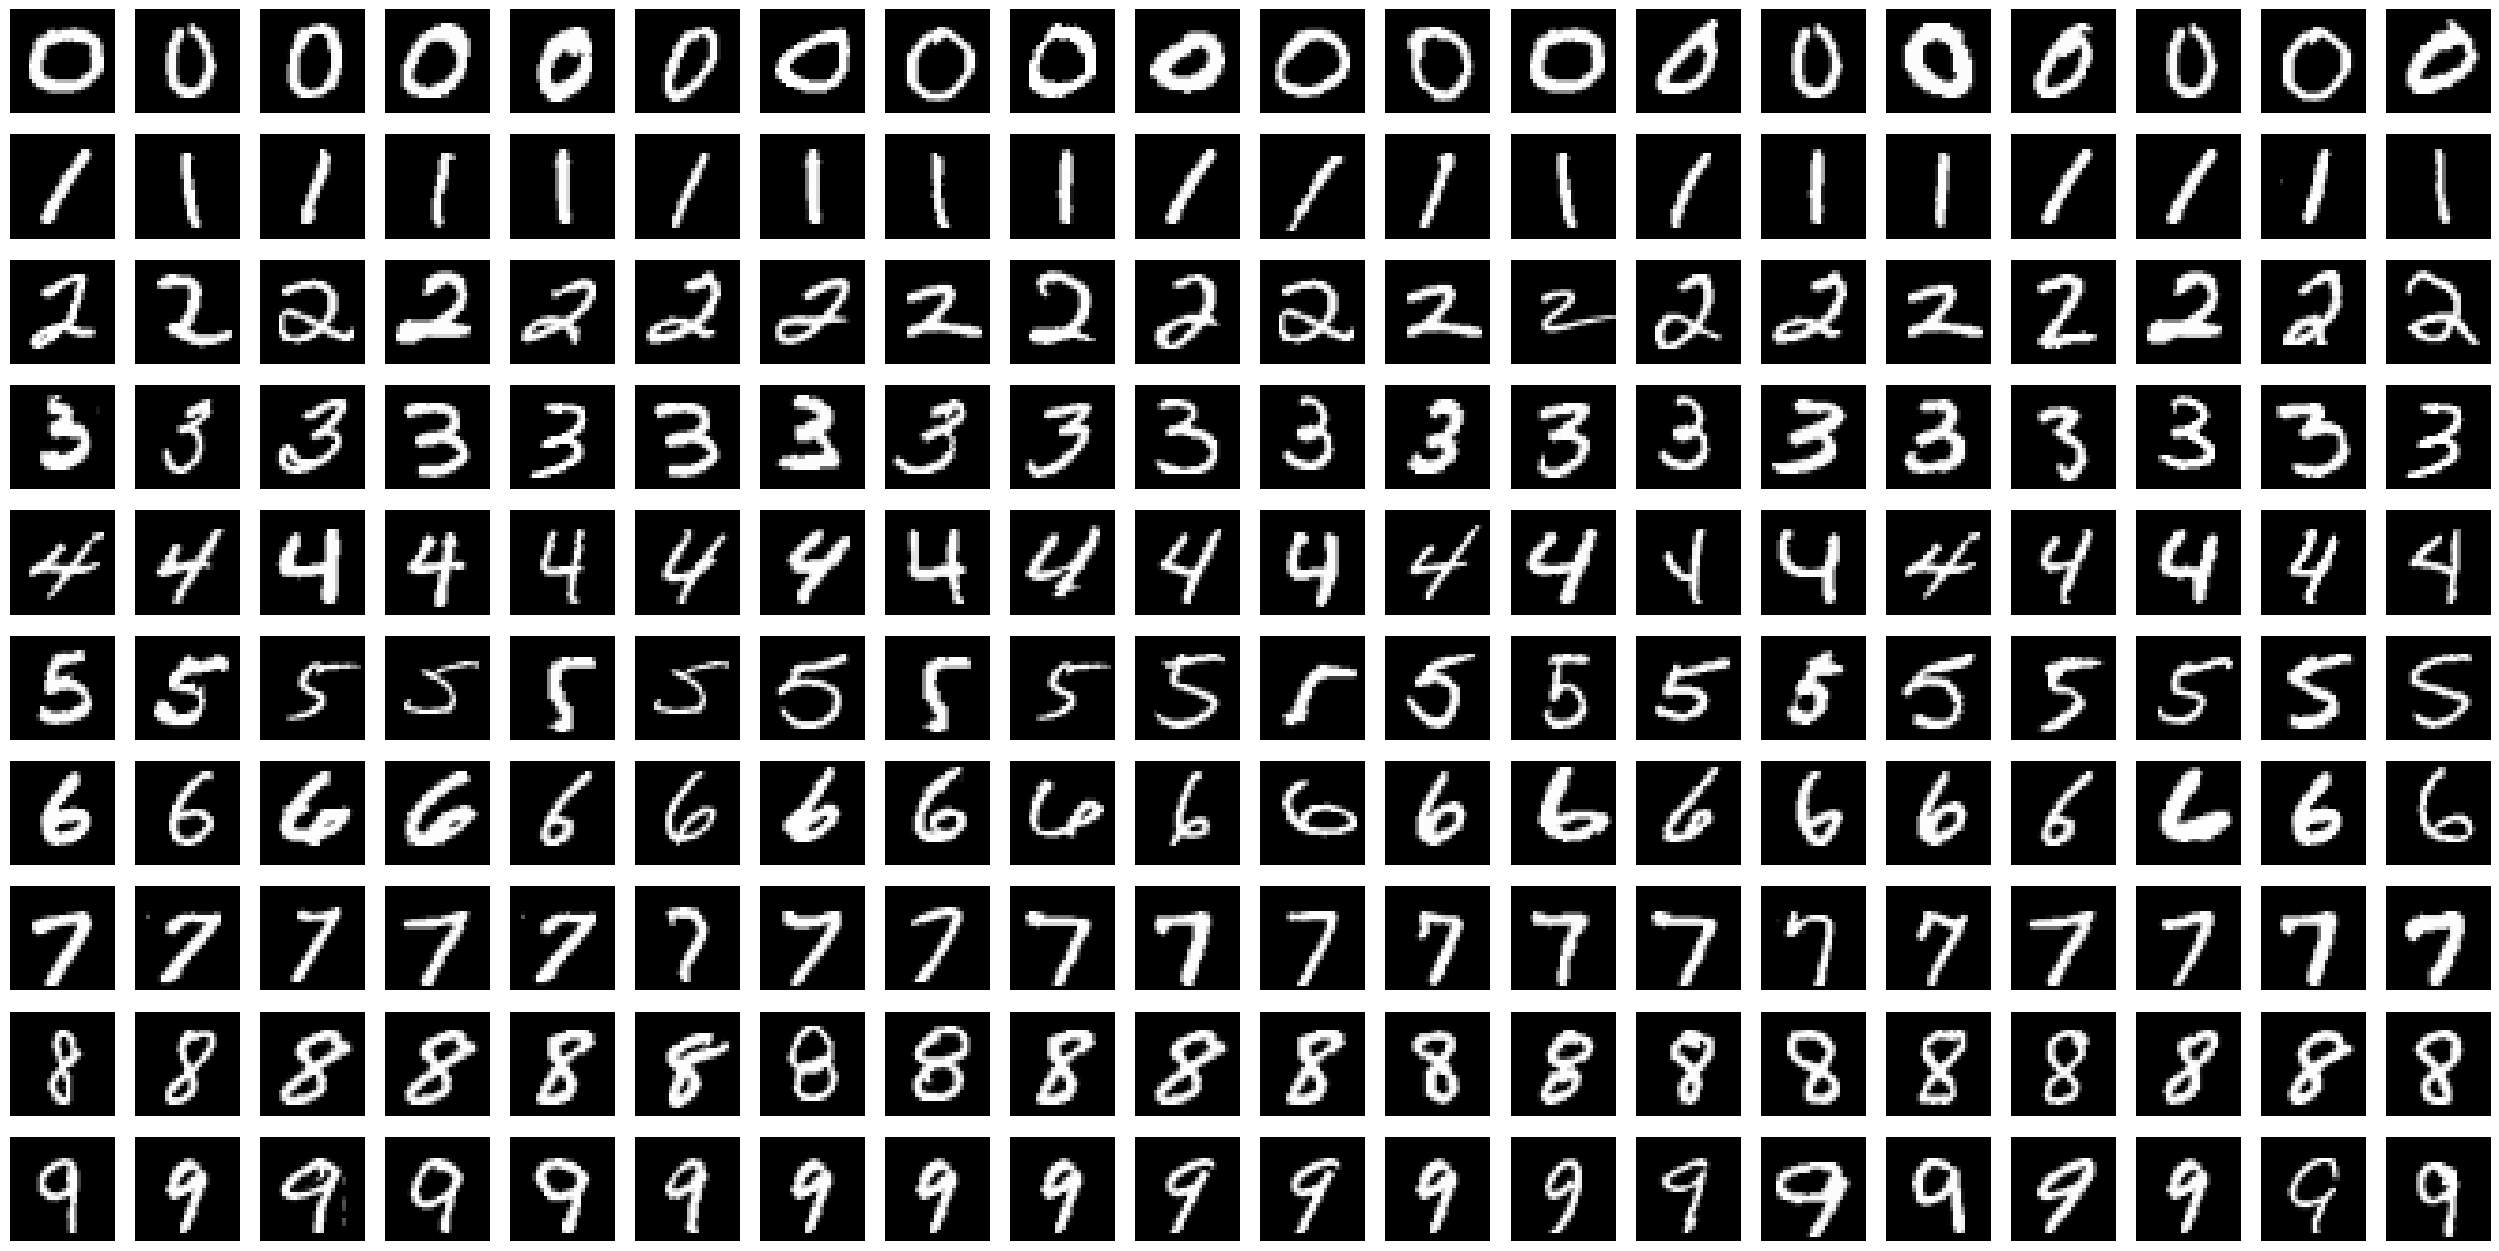

In [13]:
plt.figure(figsize=(32, 16))
for digit in range(10):
    for i in range(plot_num):
        plt.subplot(10, plot_num, digit * plot_num + i + 1)
        plt.imshow(renormalize_image(sampled_X_recons_digit[digit][i]).reshape((28, 28)), cmap='gray', vmin=0, vmax=255)
        plt.axis('off')  # Hide axes

plt.show()

# Find the nearest distance between every new sample among the training set in terms of norm.
plt.figure(figsize=(32, 16))
for digit in range(10):
    for i in range(plot_num):
        norm = [np.linalg.norm(sampled_X_recons_digit[digit][i].reshape((28, 28)) - p.reshape((28, 28))) for p in P_digit[digit]]
        idx = np.argmin(norm)
        plt.subplot(10, plot_num, digit * plot_num + i + 1)
        plt.imshow(P_digit[digit][idx].reshape((28, 28)), cmap='gray', vmin=0, vmax=255) # [0, 255]
        plt.axis('off')  # Hide axes

plt.show()

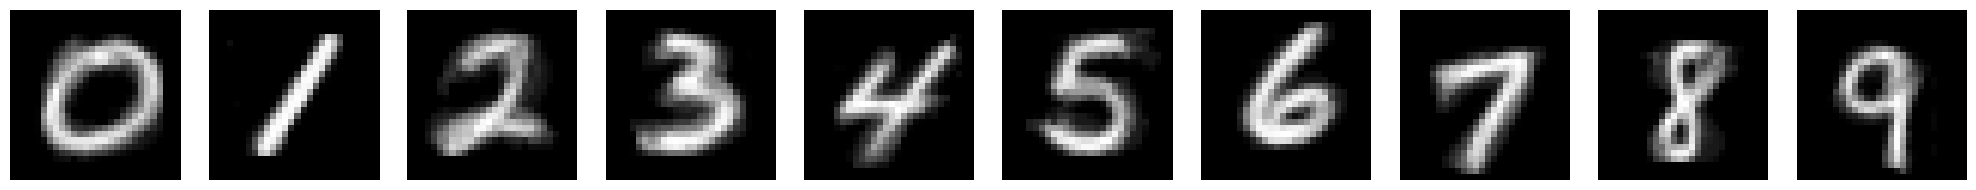

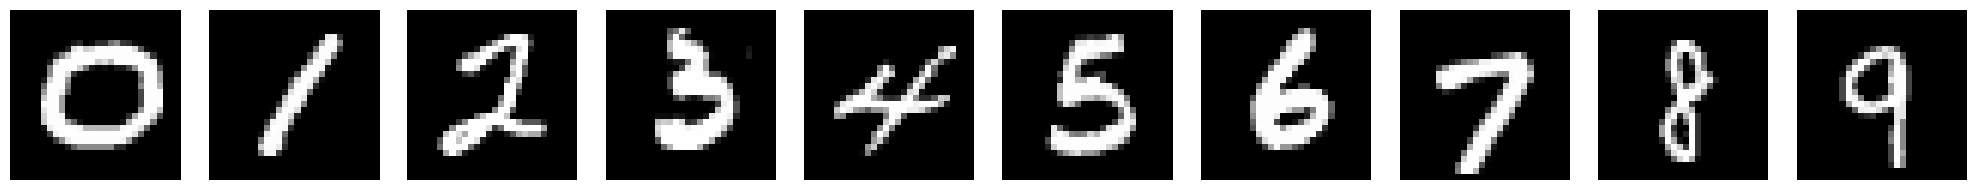

In [126]:
plt.figure(figsize=(20, 2))
for digit in range(10):
    for i in range(paper_plot_num):
        plt.subplot(paper_plot_num, 10, digit * paper_plot_num + i + 1)
        plt.imshow(renormalize_image(sampled_X_recons_digit[digit][i]).reshape((28, 28)), cmap='gray', vmin=0, vmax=255)
        plt.axis('off')  # Hide axes

plt.tight_layout()

plt.savefig('../Figures/MNIST_BP_2_body.png', format='png', dpi=300)

plt.show()

# Find the nearest distance between every new sample among the training set in terms of norm.
plt.figure(figsize=(20, 2))
for digit in range(10):
    for i in range(paper_plot_num):
        norm = [np.linalg.norm(sampled_X_recons_digit[digit][i].reshape((28, 28)) - p.reshape((28, 28))) for p in P_digit[digit]]
        idx = np.argmin(norm)
        plt.subplot(paper_plot_num, 10, digit * paper_plot_num + i + 1)
        plt.imshow(P_digit[digit][idx].reshape((28, 28)), cmap='gray', vmin=0, vmax=255) # [0, 255]
        plt.axis('off')  # Hide axes

plt.tight_layout()

plt.savefig('../Figures/MNIST_BP_2_body_compare.png', format='png', dpi=300)

plt.show()

### Store Augmented Data

In [66]:
augmented_data_LD = []

for digit in range(10):
    for i in range(num_new_samples):
        img = renormalize_image(sampled_X_recons_digit[digit][i]).reshape((28, 28))
        augmented_data_LD.append(img)

train_data_LD = np.array(augmented_data_LD)
labels = np.repeat(np.arange(10), num_new_samples)
custom_train_dataset = CustomDataset(train_data_LD, labels, transform=transforms.ToTensor())
train_loader_LD = DataLoader(dataset=custom_train_dataset, batch_size=64, shuffle=True)

### Interpolation

In [15]:
def interpolate_sum(theta_start, theta_end, interpolate_num, interpolate_B):
    """
    Perform interpolation between theta_start and theta_end and sum over specified indices.

    Parameters:
    theta_start (np.ndarray): Starting tensor.
    theta_end (np.ndarray): Ending tensor.
    interpolate_num (int): Number of interpolation steps.
    interpolate_B (list of tuples): Indices to sum over.

    Returns:
    np.ndarray: Array of interpolated tensors.
    """
    # Get the shape of the tensor
    tensor_shape = theta_start.shape

    # Create an array to store the interpolated tensors
    interpolated_thetas = np.zeros((interpolate_num,) + tensor_shape)

    # Iterate over the interpolation steps
    for i in range(interpolate_num):
        t = i / (interpolate_num - 1)  # Compute interpolation factor

        # Perform interpolation and sum over specified indices
        for basis in interpolate_B:
            index_slices = [slice(None)] * len(tensor_shape)
            index_slices = list(basis)
            interpolated_thetas[i][tuple(index_slices)] = (
                theta_start[tuple(index_slices)] + t * (theta_end[tuple(index_slices)] - theta_start[tuple(index_slices)])
            )

    return interpolated_thetas

In [16]:
theta_all = np.vstack(theta_digit)
scaleX_all = np.concatenate(scaleX_digit, axis=0)
P_all = np.vstack(P_digit)
eta_hat_all = np.vstack(eta_hat_digit)

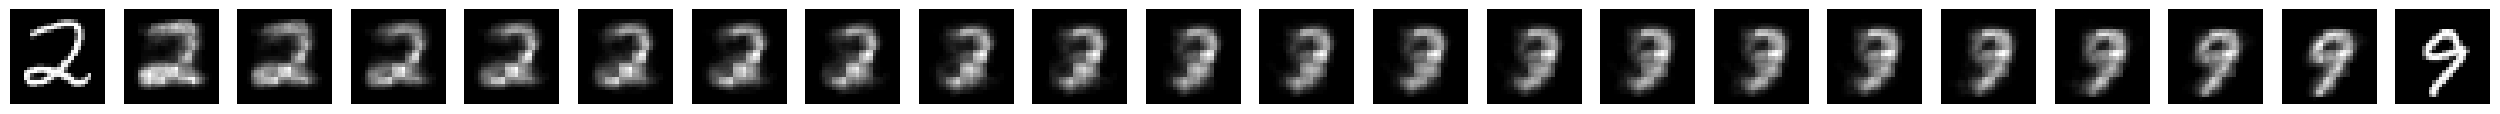

In [17]:
start_digit, end_digit = 2, 9
start_idx, end_idx = 0, 13

B_interpolate = ld.default_B(S, len(S), cp.get_array_module(P_digit[0][0]))
# B_interpolate = ld.block_B([1, 0, 0, 1, 0, 0], [6, 1, 1, 6, 1, 1])

theta_start, theta_end = theta_digit[start_digit][start_idx], theta_digit[end_digit][end_idx]

interpolate_num = 20

interpolate_theta = interpolate_sum(theta_start, theta_end, interpolate_num, B_interpolate)

interpolate_P_BP = []
interpolate_theta_BP = []
interpolate_X_recons = []

for i in range(interpolate_num):
    ks = ld.kNN(interpolate_theta[i], np.vstack(theta_digit), k=20)
    avg_scale = np.mean(scaleX_all[ks])
    avg_eta_hat = np.mean(eta_hat_all[ks], axis=0)

    history_kl, history_norm, P, theta = ld.BP(interpolate_theta[i], [(P_all[k] + eps) / scaleX_all[k] for k in ks], avg_eta_hat, avg_scale, B=B_BP, verbose=False, n_iter=1000, lr=1e-1)
    interpolate_P_BP.append(P)
    interpolate_theta_BP.append(theta)

    X_recons_ = (P).astype(np.int32)
    interpolate_X_recons.append(X_recons_)

interpolate_P_BP = np.array(interpolate_P_BP)
interpolate_theta_BP = np.array(interpolate_theta_BP)
interpolate_X_recons = np.array(interpolate_X_recons)

plt.figure(figsize=(32, 3))
plt.subplot(1, interpolate_num+2, 1)
plt.imshow(P_digit[start_digit][start_idx].reshape((28, 28)), cmap='gray', vmin=0, vmax=255)
plt.axis('off')
for i in range(interpolate_num):
    plt.subplot(1, interpolate_num+2, i + 2)
    plt.imshow(renormalize_image(interpolate_X_recons[i]).reshape((28, 28)), cmap='gray', vmin=0, vmax=255)
    plt.axis('off')

plt.subplot(1, interpolate_num+2, interpolate_num + 2)
plt.imshow(P_digit[end_digit][end_idx].reshape((28, 28)), cmap='gray', vmin=0, vmax=255)
plt.axis('off')
plt.show()

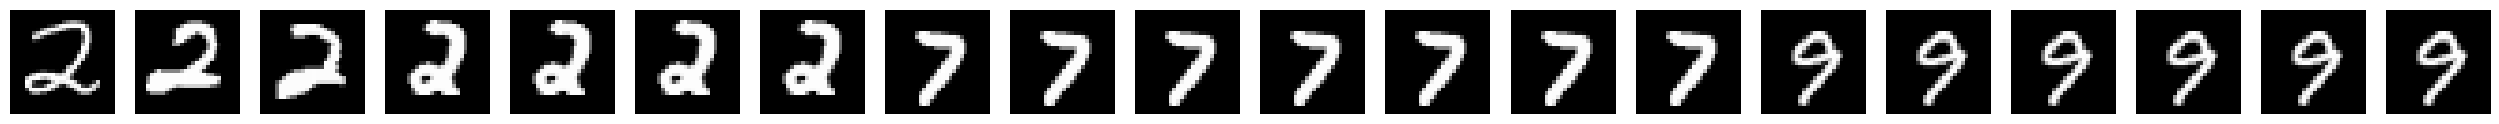

In [18]:
# Find the nearest distance between every new sample among the training set in terms of norm.
plt.figure(figsize=(32, 3))

for i in range(interpolate_num):
    norm = [np.linalg.norm(interpolate_X_recons[i].reshape((28, 28)) - p.reshape((28, 28))) for p in P_all]
    idx = np.argmin(norm)
    # print(f"Nearest distance: new sample {i} and training sample {idx}: {norm[idx]}")

    plt.subplot(1, interpolate_num, i+1)
    plt.imshow(P_all[idx].reshape((28, 28)), cmap='gray', vmin=0, vmax=255) # [0, 255]
    plt.axis('off')  # Hide axes

plt.show()

## Data Augmentation with Autoencoder

In [43]:
class Encoder(nn.Module):
    def __init__(self, input_size=28*28, hidden_size=128, z_dim=100):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        # self.fc2 = nn.Linear(hidden_size , hidden_size2)
        self.fc3 = nn.Linear(hidden_size, z_dim)
        self.relu = nn.ReLU()
    def forward(self , x):
        x = self.relu(self.fc1(x))
        # x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class Decoder(nn.Module):
    def __init__(self, output_size=28*28, hidden_size=128, z_dim=100):
        super().__init__()
        self.fc1 = nn.Linear(z_dim , hidden_size)
        # self.fc2 = nn.Linear(hidden_size , hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()
    def forward(self , x):
        x = self.relu(self.fc1(x))
        # x = self.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

In [44]:
enc = Encoder().to(device)
dec = Decoder().to(device)
loss_fn = nn.MSELoss()
optimizer_enc = torch.optim.Adam(enc.parameters())
optimizer_dec = torch.optim.Adam(dec.parameters())

100%|██████████| 1000/1000 [01:07<00:00, 14.83it/s]


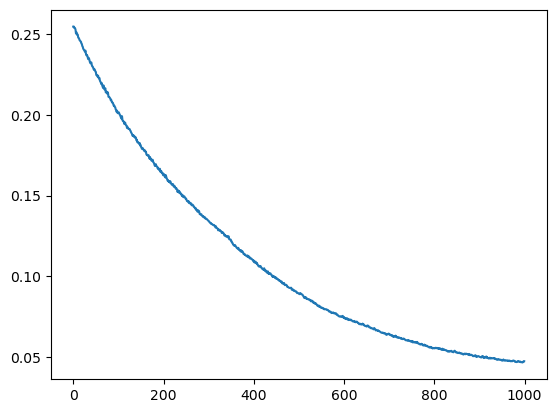

In [65]:
train_loss = []
num_epochs = 1000

for epoch in tqdm(range(num_epochs)):
    train_epoch_loss = 0
    for (imgs , _) in train_loader_original:
        imgs = imgs.to(device)
        #100 , 1 , 28 , 28 ---> (100 , 28*28)
        imgs = imgs.flatten(1)
        latents = enc(imgs)
        output = dec(latents)
        loss = loss_fn(output , imgs)
        train_epoch_loss += loss.cpu().detach().numpy()
        optimizer_enc.zero_grad()
        optimizer_dec.zero_grad()
        loss.backward()
        optimizer_enc.step()
        optimizer_dec.step()
    train_loss.append(train_epoch_loss)
plt.plot(train_loss)

In [67]:
representation = None
AE_imgs = None
all_labels = []

with torch.no_grad():
    for (imgs , labels) in train_loader_original:
        imgs = imgs.to(device)
        imgs = imgs.flatten(1)
        all_labels.extend(list(labels.numpy()))
        latents = enc(imgs)
        if representation is None:
            representation = latents.cpu()
        else:
            representation = torch.vstack([representation , latents.cpu()])

        if AE_imgs is None:
            AE_imgs = imgs.detach().cpu().numpy()
        else:
            AE_imgs = np.vstack([AE_imgs , imgs.detach().cpu().numpy()])

AE_digit = []
for digit in range(10):
    AE_digit.append(AE_imgs[torch.tensor(all_labels) == digit])

all_labels = np.array(all_labels)
representation = representation.numpy()

In [116]:
num_new_samples = 20

sampled_AE_digit = []

for digit in range(10):
    sampled_AE_list = []

    rep = representation[np.argwhere(all_labels == digit)].squeeze()
    # Fit a KDE to the theta values
    kde = KernelDensity(kernel='gaussian', bandwidth=0.5).fit(rep)

    # Sample new data from the KDE
    sampled_rep = kde.sample(n_samples=num_new_samples)
    for i in range(num_new_samples):
        pred = dec(torch.Tensor(sampled_rep[i])[None , ...].to(device)).cpu().detach().numpy()
        sampled_AE_list.append(pred)

    sampled_AE_digit.append(sampled_AE_list)

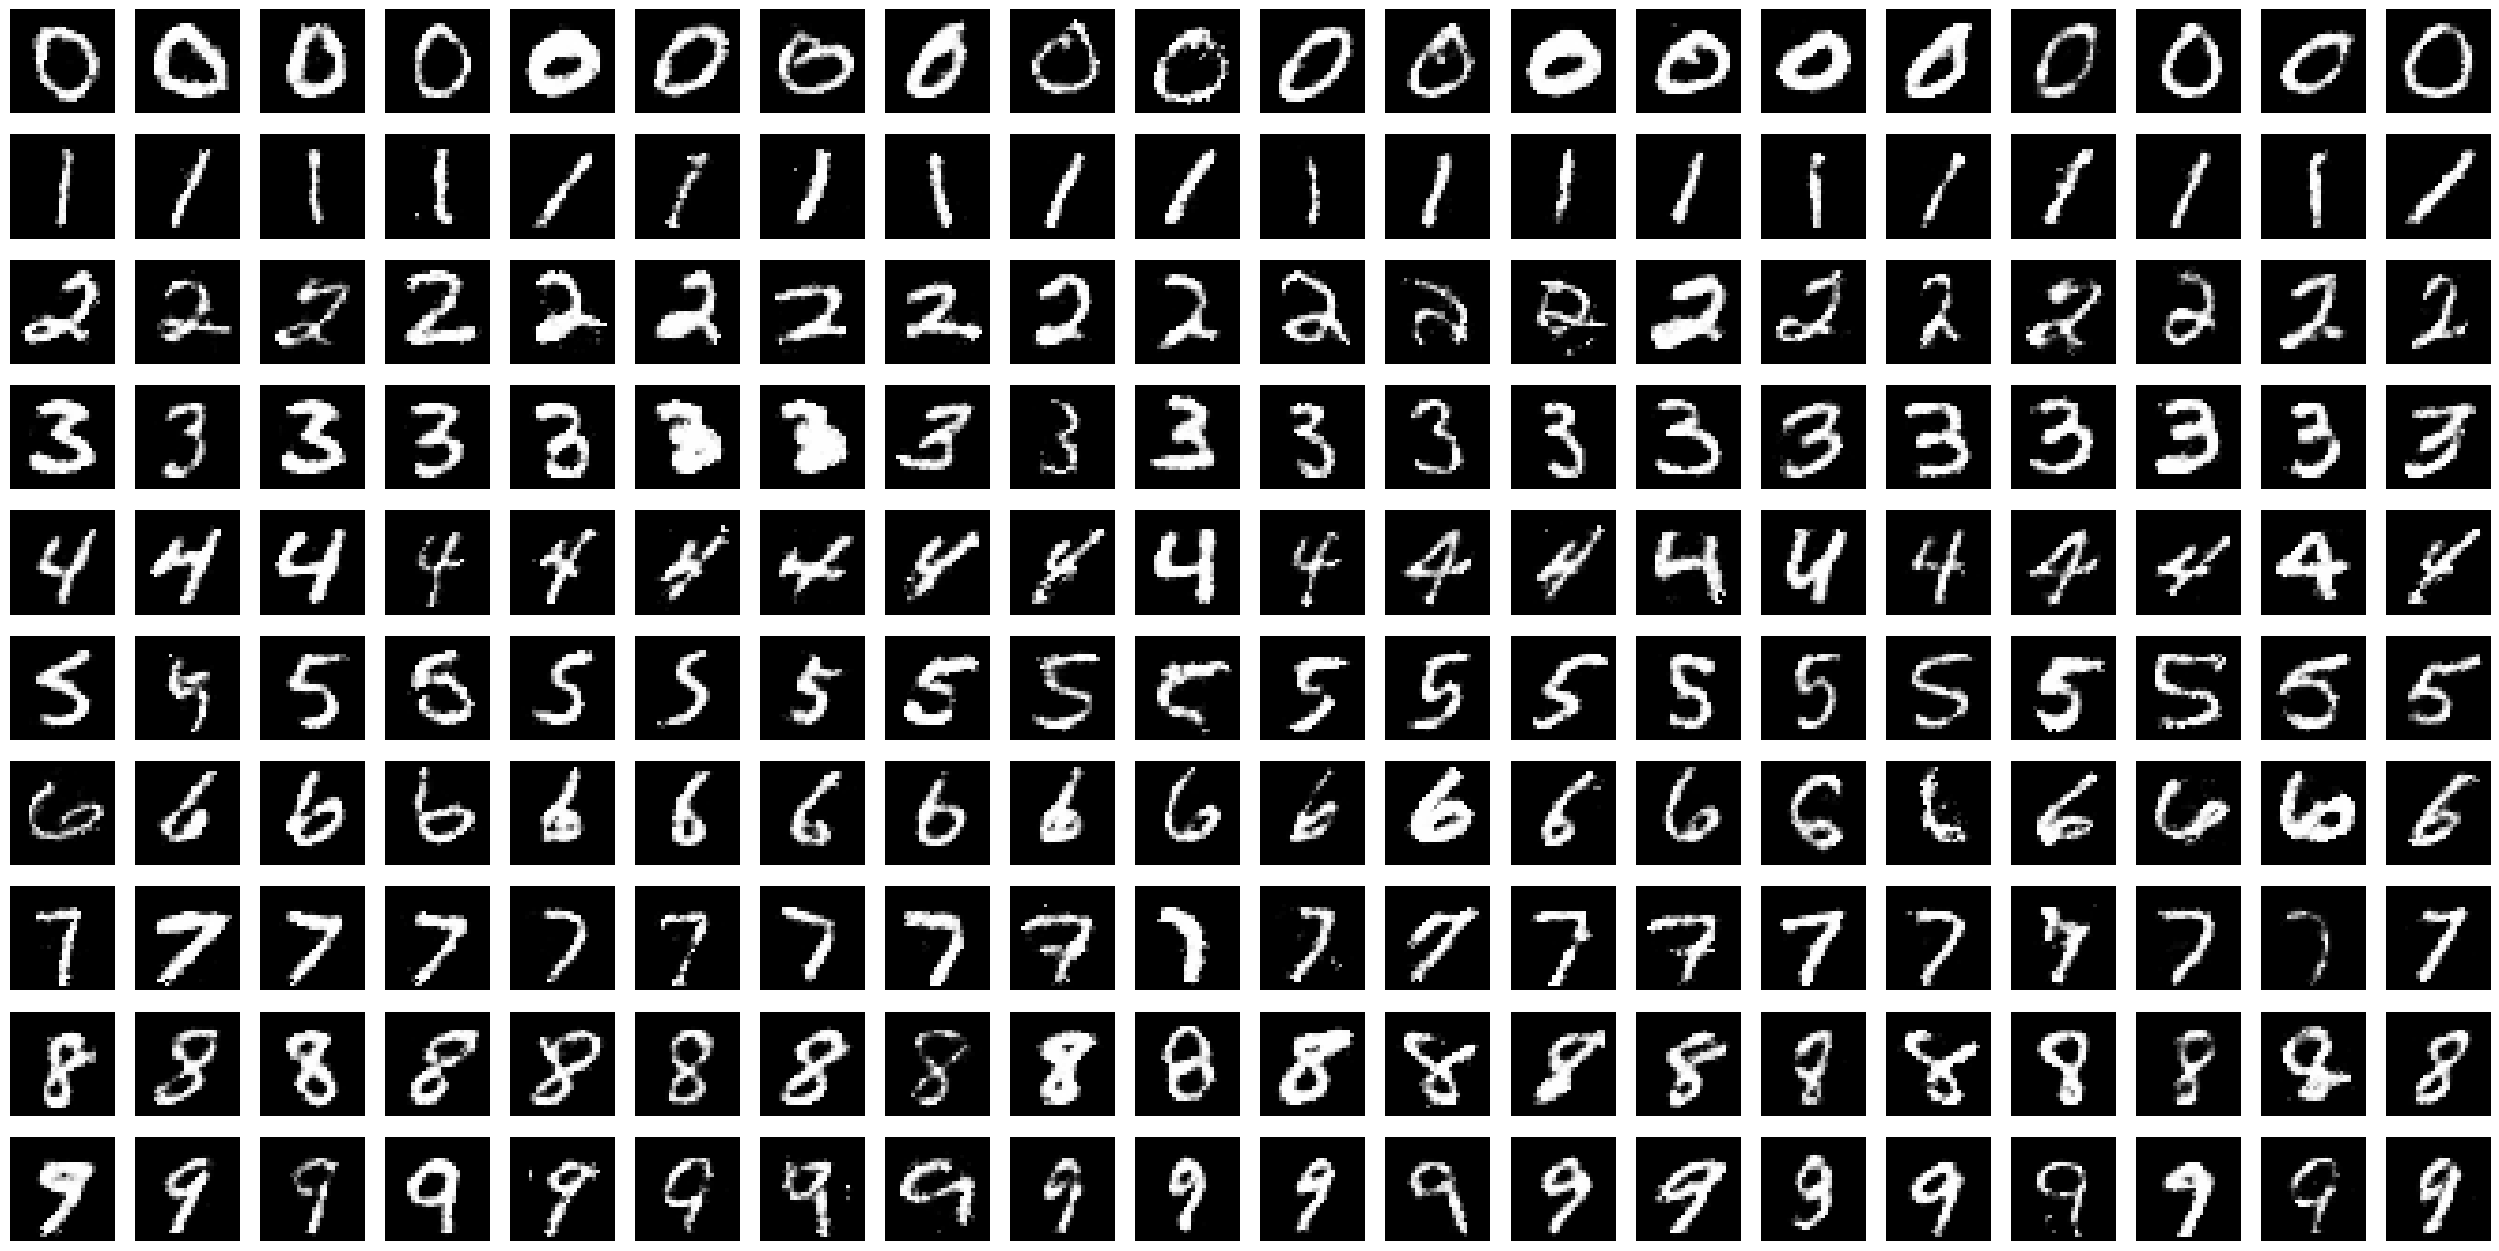

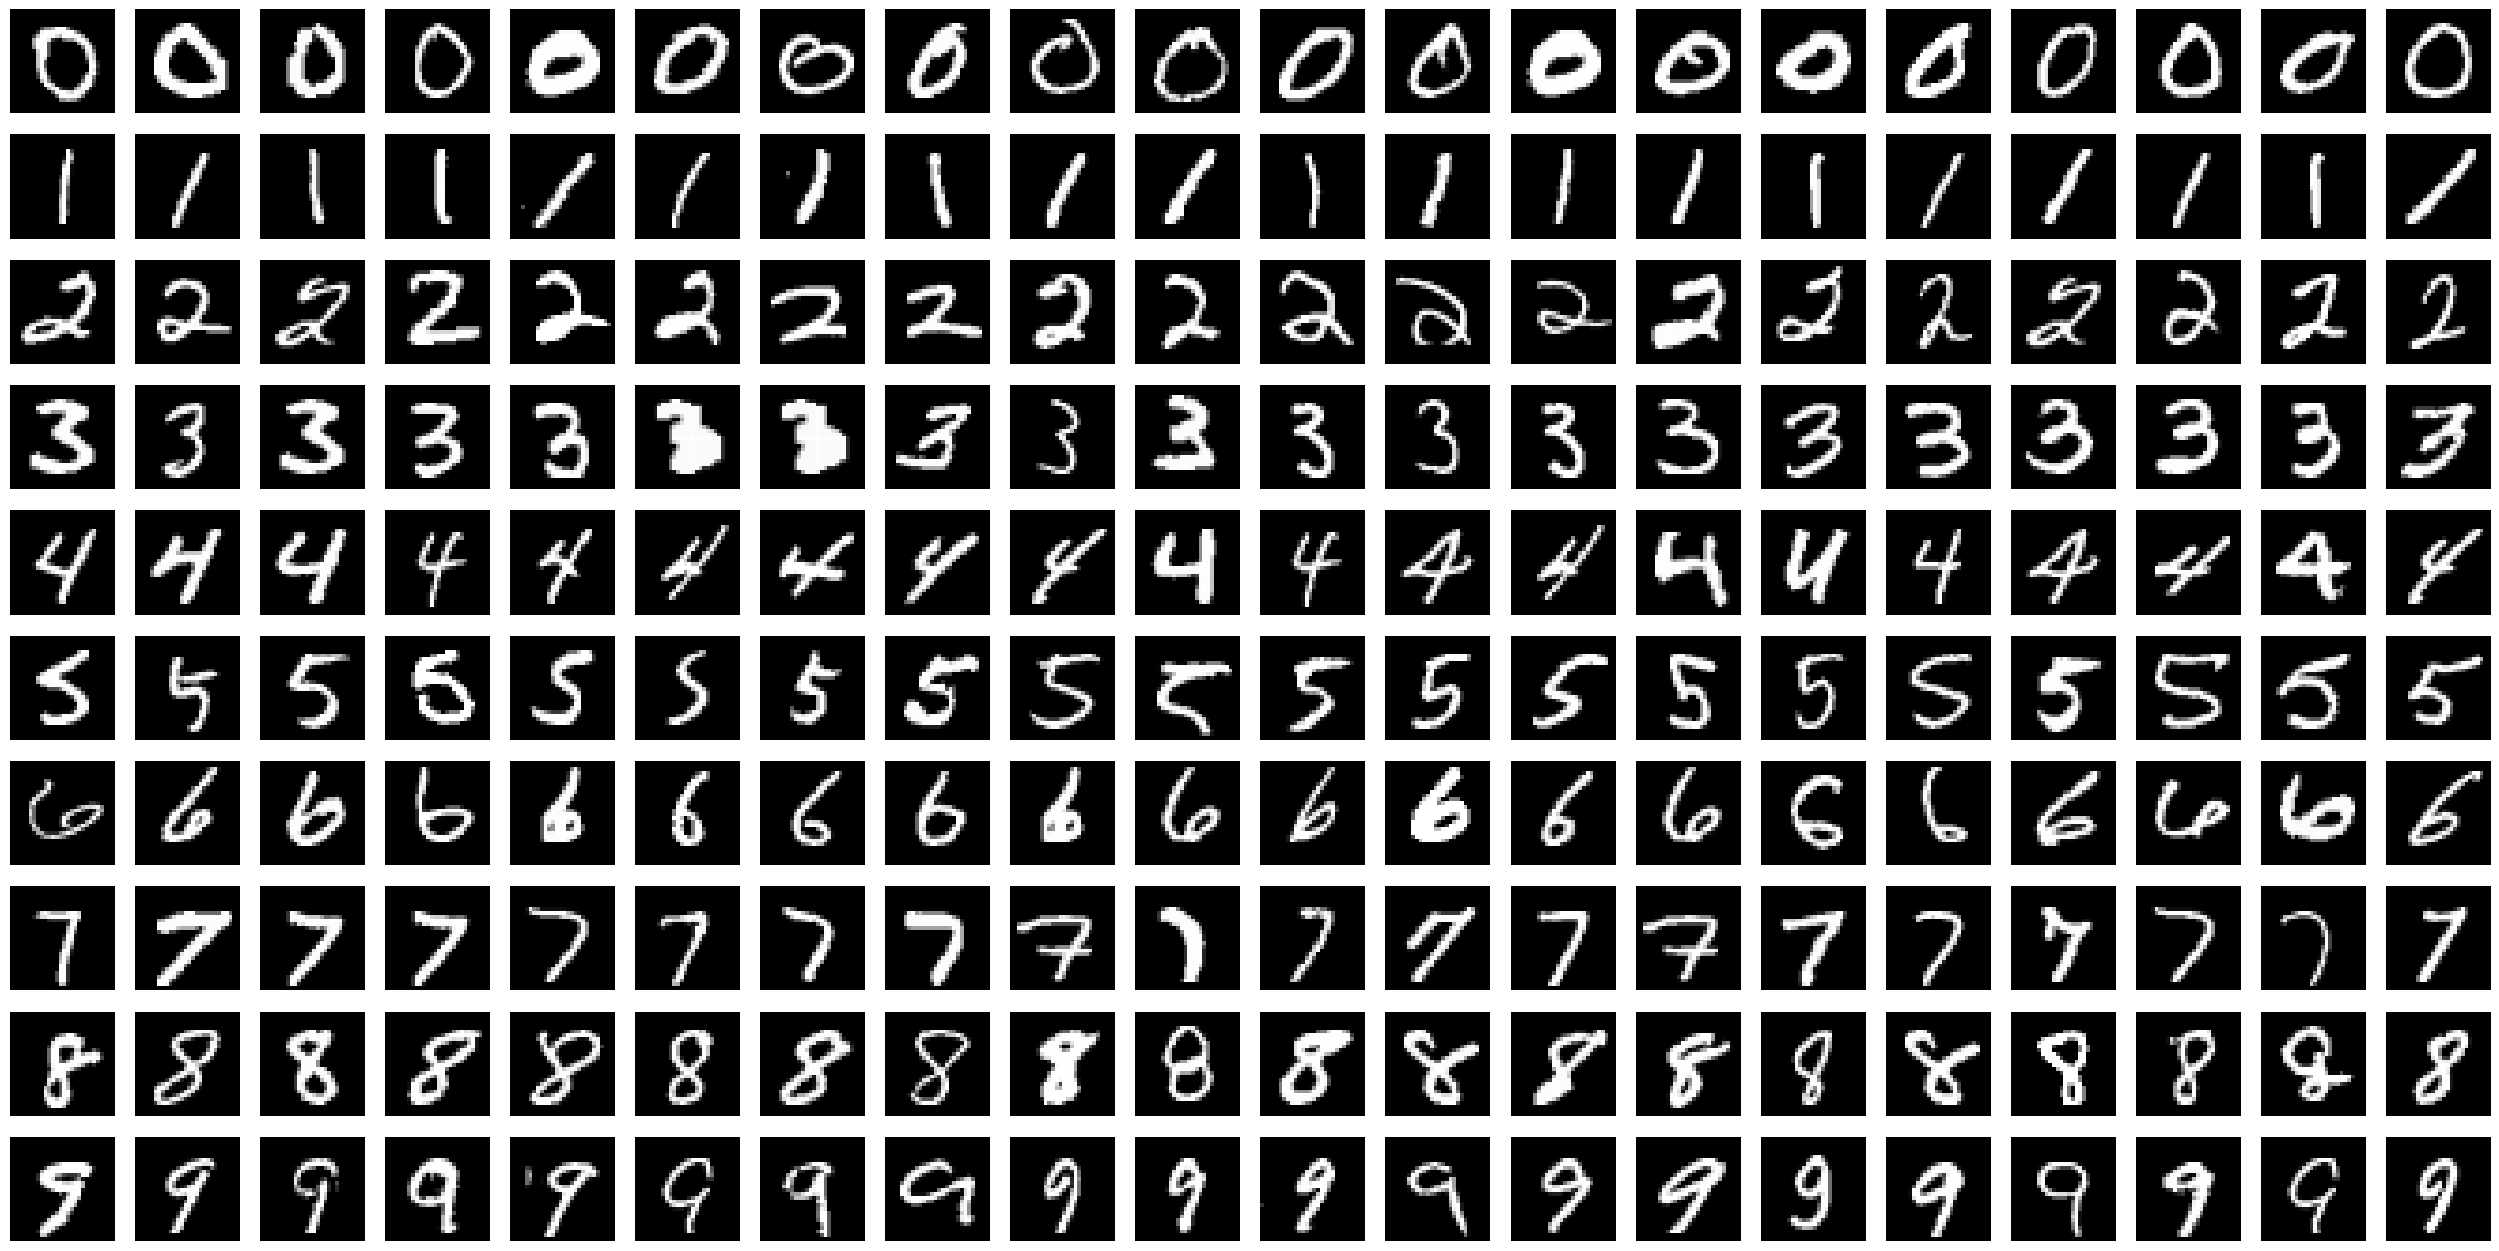

In [117]:
plt.figure(figsize=(32, 16))
for digit in range(10):
    for i in range(plot_num):
        plt.subplot(10, plot_num, digit * plot_num + i + 1)
        plt.imshow(renormalize_image(sampled_AE_digit[digit][i]).reshape(28, 28), cmap='gray', vmin=0, vmax=255)
        plt.axis('off')  # Hide axes

plt.show()

# Find the nearest distance between every new sample among the training set in terms of norm.
plt.figure(figsize=(32, 16))
for digit in range(10):
    for i in range(plot_num):
        norm = [np.linalg.norm(sampled_AE_digit[digit][i].reshape((28, 28)) - p.reshape((28, 28))) for p in AE_digit[digit]]
        idx = np.argmin(norm)
        plt.subplot(10, plot_num, digit * plot_num + i + 1)
        plt.imshow(renormalize_image(AE_digit[digit][idx]).reshape((28, 28)), cmap='gray', vmin=0, vmax=255) # [0, 255]
        plt.axis('off')  # Hide axes

plt.show()

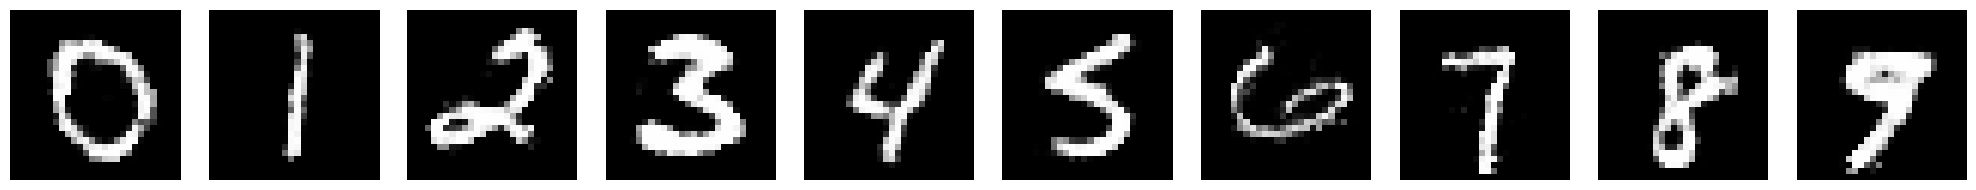

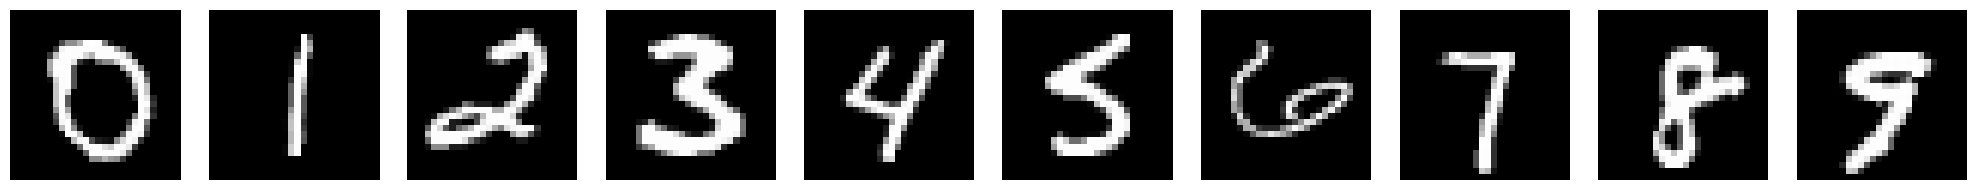

In [127]:
plt.figure(figsize=(20, 2))
for digit in range(10):
    for i in range(paper_plot_num):
        plt.subplot(paper_plot_num, 10, digit * paper_plot_num + i + 1)
        plt.imshow(renormalize_image(sampled_AE_digit[digit][i]).reshape(28, 28), cmap='gray', vmin=0, vmax=255)
        plt.axis('off')  # Hide axes

plt.tight_layout()

plt.savefig('../Figures/MNIST_AE.png', format='png', dpi=300)

plt.show()

# Find the nearest distance between every new sample among the training set in terms of norm.
plt.figure(figsize=(20, 2))
for digit in range(10):
    for i in range(paper_plot_num):
        norm = [np.linalg.norm(sampled_AE_digit[digit][i].reshape((28, 28)) - p.reshape((28, 28))) for p in AE_digit[digit]]
        idx = np.argmin(norm)
        plt.subplot(paper_plot_num, 10, digit * paper_plot_num + i + 1)
        plt.imshow(renormalize_image(AE_digit[digit][idx]).reshape((28, 28)), cmap='gray', vmin=0, vmax=255) # [0, 255]
        plt.axis('off')  # Hide axes

plt.tight_layout()

plt.savefig('../Figures/MNIST_AE_compare.png', format='png', dpi=300)

plt.show()

### Store Augmented Data

In [98]:
augmented_data_AE = []

for digit in range(10):
    for i in range(num_new_samples):
        img = renormalize_image(sampled_AE_digit[digit][i]).reshape((28, 28))
        augmented_data_AE.append(img)

train_data_AE = np.array(augmented_data_AE)
labels = np.repeat(np.arange(10), num_new_samples)
custom_train_dataset = CustomDataset(train_data_AE, labels, transform=transforms.ToTensor())
train_loader_AE = DataLoader(dataset=custom_train_dataset, batch_size=64, shuffle=True)

## Classification Performance

### Logistic Regression Model

In [99]:
class LogisticRegressionModel(nn.Module):
    def __init__(self):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(28*28, 10)  # 28x28 input size, 10 output classes

    def forward(self, x):
        x = x.view(-1, 28*28)  # Flatten the image into a vector of size 28*28
        out = self.linear(x)   # Linear transformation
        return out

# Function to train the model
def train_model(model, train_loader, criterion, optimizer, num_epochs=5, device='cpu'):
    model.to(device)
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        running_loss = 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

# Function to test the model
def test_model(model, test_loader, device='cpu'):
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Accuracy of the model on the test images: {accuracy:.2f}%')
    return accuracy

# Main function to run training and testing on a dataset
def run(train_loader, test_loader, num_epochs=5, learning_rate=0.01, device='cpu'):
    # Initialize model, loss function, and optimizer
    model = LogisticRegressionModel().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)

    # Train the model
    train_model(model, train_loader, criterion, optimizer, num_epochs=num_epochs, device=device)

    # Test the model
    accuracy = test_model(model, test_loader, device=device)
    return accuracy

In [128]:
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

print(f"Number of test samples: {len(test_loader.dataset)}")

Number of test samples: 10000


### Original Dataset

In [101]:
accuracy = run(train_loader_original, test_loader, num_epochs=20, learning_rate=0.01, device=device)
print(f'Final Test Accuracy on MNIST: {accuracy:.2f}%')

Epoch [1/20], Loss: 2.2130
Epoch [2/20], Loss: 2.0563
Epoch [3/20], Loss: 1.9220
Epoch [4/20], Loss: 1.8030
Epoch [5/20], Loss: 1.6985
Epoch [6/20], Loss: 1.6056
Epoch [7/20], Loss: 1.5176
Epoch [8/20], Loss: 1.4419
Epoch [9/20], Loss: 1.3802
Epoch [10/20], Loss: 1.3172
Epoch [11/20], Loss: 1.2654
Epoch [12/20], Loss: 1.2161
Epoch [13/20], Loss: 1.1673
Epoch [14/20], Loss: 1.1314
Epoch [15/20], Loss: 1.0961
Epoch [16/20], Loss: 1.0606
Epoch [17/20], Loss: 1.0263
Epoch [18/20], Loss: 0.9985
Epoch [19/20], Loss: 0.9753
Epoch [20/20], Loss: 0.9492
Accuracy of the model on the test images: 82.55%
Final Test Accuracy on MNIST: 82.55%


### Augmented Dataset

#### Log-Linear Model

In [102]:
accuracy = run(train_loader_LD, test_loader, num_epochs=20, learning_rate=0.01, device=device)
print(f'Final Test Accuracy on MNIST: {accuracy:.2f}%')

Epoch [1/20], Loss: 2.3112
Epoch [2/20], Loss: 2.2354
Epoch [3/20], Loss: 2.1763
Epoch [4/20], Loss: 2.1516
Epoch [5/20], Loss: 2.1015
Epoch [6/20], Loss: 2.0666
Epoch [7/20], Loss: 1.9949
Epoch [8/20], Loss: 1.9409
Epoch [9/20], Loss: 1.8827
Epoch [10/20], Loss: 1.8598
Epoch [11/20], Loss: 1.8038
Epoch [12/20], Loss: 1.7874
Epoch [13/20], Loss: 1.7030
Epoch [14/20], Loss: 1.6486
Epoch [15/20], Loss: 1.6567
Epoch [16/20], Loss: 1.6284
Epoch [17/20], Loss: 1.5573
Epoch [18/20], Loss: 1.4996
Epoch [19/20], Loss: 1.5300
Epoch [20/20], Loss: 1.4888
Accuracy of the model on the test images: 72.46%
Final Test Accuracy on MNIST: 72.46%


#### Autoencoder

In [103]:
accuracy = run(train_loader_AE, test_loader, num_epochs=20, learning_rate=0.01, device=device)
print(f'Final Test Accuracy on MNIST: {accuracy:.2f}%')

Epoch [1/20], Loss: 2.2269
Epoch [2/20], Loss: 2.1950
Epoch [3/20], Loss: 2.1477
Epoch [4/20], Loss: 2.0979
Epoch [5/20], Loss: 2.0620
Epoch [6/20], Loss: 1.9970
Epoch [7/20], Loss: 1.9690
Epoch [8/20], Loss: 1.9407
Epoch [9/20], Loss: 1.9161
Epoch [10/20], Loss: 1.8262
Epoch [11/20], Loss: 1.7992
Epoch [12/20], Loss: 1.8254
Epoch [13/20], Loss: 1.7573
Epoch [14/20], Loss: 1.6946
Epoch [15/20], Loss: 1.6223
Epoch [16/20], Loss: 1.7593
Epoch [17/20], Loss: 1.6209
Epoch [18/20], Loss: 1.6449
Epoch [19/20], Loss: 1.6398
Epoch [20/20], Loss: 1.6167
Accuracy of the model on the test images: 66.38%
Final Test Accuracy on MNIST: 66.38%


### Original and Augmented Dataset

#### Log-Linear Model

In [107]:
train_data = np.vstack([train_data_original, train_data_LD])
labels = np.hstack([np.repeat(np.arange(10), train_size), np.repeat(np.arange(10), num_new_samples)])
custom_train_dataset = CustomDataset(train_data, labels, transform=transforms.ToTensor())

train_loader = DataLoader(dataset=custom_train_dataset, batch_size=64, shuffle=True)
accuracy = run(train_loader, test_loader, num_epochs=20, learning_rate=0.01, device=device)
print(f'Final Test Accuracy on MNIST: {accuracy:.2f}%')

Epoch [1/20], Loss: 2.2050
Epoch [2/20], Loss: 2.0207
Epoch [3/20], Loss: 1.8614
Epoch [4/20], Loss: 1.7232
Epoch [5/20], Loss: 1.6025
Epoch [6/20], Loss: 1.4981
Epoch [7/20], Loss: 1.4041
Epoch [8/20], Loss: 1.3231
Epoch [9/20], Loss: 1.2518
Epoch [10/20], Loss: 1.1888
Epoch [11/20], Loss: 1.1326
Epoch [12/20], Loss: 1.0828
Epoch [13/20], Loss: 1.0396
Epoch [14/20], Loss: 1.0000
Epoch [15/20], Loss: 0.9628
Epoch [16/20], Loss: 0.9296
Epoch [17/20], Loss: 0.8991
Epoch [18/20], Loss: 0.8740
Epoch [19/20], Loss: 0.8468
Epoch [20/20], Loss: 0.8258
Accuracy of the model on the test images: 82.65%
Final Test Accuracy on MNIST: 82.65%


#### Autoencoder

In [108]:
train_data = np.vstack([train_data_original, train_data_AE])
labels = np.hstack([np.repeat(np.arange(10), train_size), np.repeat(np.arange(10), num_new_samples)])
custom_train_dataset = CustomDataset(train_data, labels, transform=transforms.ToTensor())

train_loader = DataLoader(dataset=custom_train_dataset, batch_size=64, shuffle=True)
accuracy = run(train_loader, test_loader, num_epochs=20, learning_rate=0.01, device=device)
print(f'Final Test Accuracy on MNIST: {accuracy:.2f}%')

Epoch [1/20], Loss: 2.2426
Epoch [2/20], Loss: 2.0604
Epoch [3/20], Loss: 1.9029
Epoch [4/20], Loss: 1.7662
Epoch [5/20], Loss: 1.6491
Epoch [6/20], Loss: 1.5447
Epoch [7/20], Loss: 1.4533
Epoch [8/20], Loss: 1.3724
Epoch [9/20], Loss: 1.3032
Epoch [10/20], Loss: 1.2410
Epoch [11/20], Loss: 1.1854
Epoch [12/20], Loss: 1.1378
Epoch [13/20], Loss: 1.0934
Epoch [14/20], Loss: 1.0500
Epoch [15/20], Loss: 1.0173
Epoch [16/20], Loss: 0.9824
Epoch [17/20], Loss: 0.9519
Epoch [18/20], Loss: 0.9262
Epoch [19/20], Loss: 0.9011
Epoch [20/20], Loss: 0.8755
Accuracy of the model on the test images: 83.75%
Final Test Accuracy on MNIST: 83.75%
